# Source re-analysis 

Simpler analysis, relying on ANOVAs and collapsing over encoding side, but **not** task in retrieval analyses.

In [112]:
# Get the username and use that to set-up paths to data and figures
uname  = !whoami
uname = uname[0]
path2code = '/Users/' + uname + '/Work/Expts/Code/'
path2data = '/Users/' + uname + '/Work/Expts/SOURCE/Data/'
path2analysis = '/Users/' + uname + '/Work/Expts/SOURCE/Analysis/'
path2figs = '/Users/' + uname + '/Work/Expts/SOURCE/Analysis/Figures/'
path2stims = '/Users/' + uname + '/Work/Expts/SOURCE/PsychoPy/Stimuli/'
path2erps = '/Users/' + uname + '/Work/Expts/SOURCE/Analysis/ERPs/'

In [114]:
%cd {path2code}

import csv, misc, os, re, SelfRep
import numpy as np
import pandas as pd
import seaborn as sns
import scipy as sp
from matplotlib import pyplot as plt
%matplotlib inline
%load_ext rpy2.ipython

%R library('ez')
%R library('mutoss')
%R library('lmerTest')
%R library('lsmeans')
%R lsm.options(disable.pbkrtest=TRUE)
%R library('effsize')
%R library ('afex')

/Users/ebarrick/Work/Expts/Code
The rpy2.ipython extension is already loaded. To reload it, use:
  %reload_ext rpy2.ipython

Error in library("effsize") : there is no package called ‘effsize’


array(['afex', 'reshape2', 'lsmeans', 'estimability', 'lmerTest', 'lme4',
       'Matrix', 'mutoss', 'mvtnorm', 'ez', 'tools', 'stats', 'graphics',
       'grDevices', 'utils', 'datasets', 'methods', 'base'], 
      dtype='|S12')

In [116]:
def print_full(x):
    pd.set_option('display.max_rows', len(x))
    print(x)
    pd.reset_option('display.max_rows')

In [118]:
sns.set_style('darkgrid')

## Encoding

In [120]:
# Assemble the trial-level encoding data . . . 

%cd {path2data}

e_dfs = []
ef_d = re.compile('Source_enc')

subjects = !ls -d SM0*

for subject in subjects:
    curr_path = path2data + subject
    for root, dirs, files in os.walk(curr_path):
        for filename in files:
            ef_m = ef_d.search(filename)
            if ef_m:
                file_path = curr_path + '/CSV/' + filename
                e_df = pd.read_csv(file_path)
                e_df['subject'] = subject
                e_dfs.append(e_df)
                
enc_data = pd.concat(e_dfs)
enc_data.RT = enc_data.RT.map(lambda x : np.nan if x < 0 else x) # Set RT to np.nan if negative (e.g., SM045, SM046)

/Users/ebarrick/Work/Expts/SOURCE/Data


In [122]:
# Assemble self-report and demographics
demo = SelfRep.demo_proc(path2data + 'SOURCE_SelfReport_Data.xlsx')
bdi = SelfRep.bdi_proc(path2data + 'SOURCE_SelfReport_Data.xlsx')
masq = SelfRep.masq_proc(path2data + 'SOURCE_SelfReport_Data.xlsx')
rsq = SelfRep.rsq_proc(path2data + 'SOURCE_SelfReport_Data.xlsx')
psqi = SelfRep.psqi_proc(path2data + 'SOURCE_SelfReport_Data.xlsx')
wtar = SelfRep.wtar_proc(path2data + 'SOURCE_SelfReport_Data.xlsx')

sr = pd.merge(left=demo,right=bdi,left_on='subject',right_on='subject')
sr = pd.merge(left=sr,right=masq,left_on='subject',right_on='subject')
sr = pd.merge(left=sr,right=rsq,left_on='subject',right_on='subject')
sr = pd.merge(left=sr,right=psqi,left_on='subject',right_on='subject')
sr = pd.merge(left=sr,right=wtar,left_on='subject',right_on='subject')

In [124]:
# Merge the encoding and self-report data, then drop subjects based on the MINI
all_subs = pd.merge(enc_data,sr,on='subject')
del all_subs['Notes']
all_subs.Group = all_subs.Group.astype(int)
all_subs.Gender = all_subs.Gender.astype(str)
all_subs.Race = all_subs.Race.astype(str)
all_subs['Highest Degree'] = all_subs['Highest Degree'].astype(str)
all_subs.Occupation = all_subs.Occupation.astype(str)
all_subs.Income = all_subs.Income.astype(str)
all_subs.Inclusion = all_subs.Inclusion.astype(int)
enc = all_subs[all_subs.Inclusion == 1]

In [126]:
# Number of usable subjects per group (not taking ERP data quality into account)
enc.groupby('Group')['subject'].nunique()

Group
0    34
1    26
Name: subject, dtype: int64

In [128]:
# List of participants with usable ERPs
erpSubs_all = ['SM011', 'SM013', 'SM014', 'SM017', 'SM018', 'SM019', 'SM021', 'SM022', 
               'SM023', 'SM024', 'SM028', 'SM032', 'SM040', 'SM041', 'SM042', 'SM043', 
               'SM044', 'SM045', 'SM056', 'SM058', 'SM070', 'SM072', 'SM036', 'SM035', 
               'SM015', 'SM026', 'SM031', 'SM037', 'SM038', 'SM039', 'SM046', 'SM047', 
               'SM048', 'SM049', 'SM050', 'SM051', 'SM055', 'SM059', 'SM060', 'SM062', 
               'SM063', 'SM064', 'SM066', 'SM067', 'SM069', 'SM071', 'SM073', 'SM074']

In [130]:
# Track encoding accuracy and add to df
d = {}
d[1] = {'vitality': 'living', 'mobility': 'immobile'}
d[2] = {'vitality': 'non-living', 'mobility': 'immobile'}
d[3] = {'vitality': 'living', 'mobility': 'mobile'}
d[4] = {'vitality': 'non-living', 'mobility': 'mobile'}

accuracy = []
for i, row_i in enc.iterrows():
    if row_i.response == 'no_response':
        accuracy.append(999)
    elif row_i.response in d[row_i.type].values():
        accuracy.append(1)
    else:
        accuracy.append(0)
enc['accuracy'] = accuracy
enc.task = enc.task.replace(to_replace={'living_non-living':'animacy','mobile_immobile':'mobility'})
enc.Group = enc.Group.replace(to_replace={0:'control',1:'MDD'})
enc.rename(columns={'Group':'group'},inplace=True)
enc['RT (ms)'] = 1000*enc.RT

/Users/ebarrick/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/Users/ebarrick/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


In [132]:
enc_clean = enc[~(enc.accuracy == 999)] # Was having difficulty dropping NaNs for accuracy . . . 

In [134]:
# Okay, since we're very much focused on the ERP group, I'm running with data analysis on the ERP subs.
# Maybe when I'm done I will confirm with the larger group (but since their ERPs are bad their behavior may be bad)
erp_enc = enc_clean[enc_clean.subject.isin(erpSubs_all)]
erp_enc.groupby('group')['subject'].nunique()

group
MDD        24
control    24
Name: subject, dtype: int64

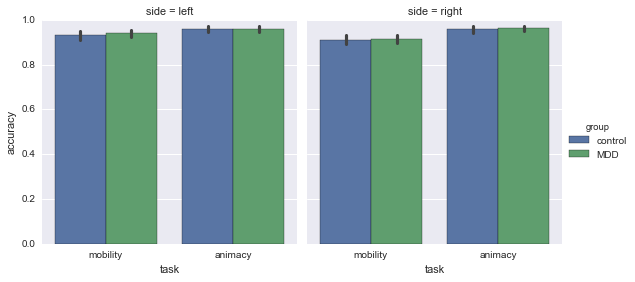

In [136]:
sns.factorplot(y='accuracy',x='task',hue='group',col='side',units='subject',ci=68,kind='bar',data=erp_enc)
sns.plt.savefig(path2figs + 'Enc_acc.pdf')

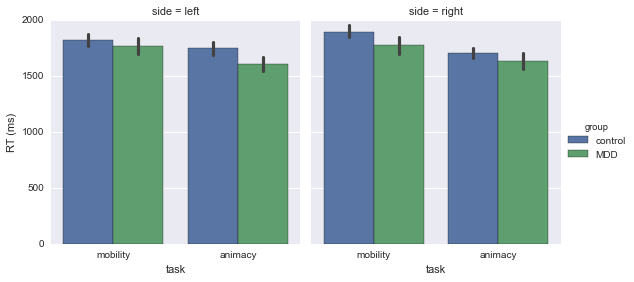

In [138]:
# RT
sns.factorplot(y='RT (ms)',x='task',hue='group',col='side',units='subject',ci=68,kind='bar',data=erp_enc)

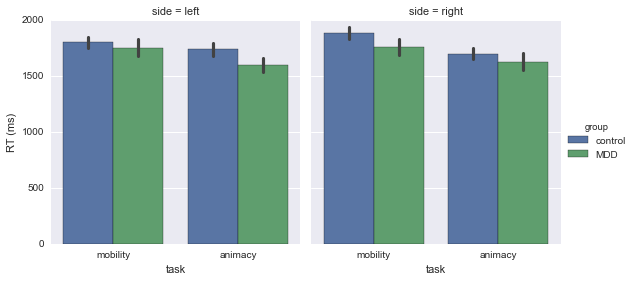

In [140]:
# Accuracy is so high that limiting RT to correct responses probably won't make much difference, but let's check.
# Nope, not much different . . . 
sns.factorplot(y='RT (ms)',x='task',hue='group',col='side',units='subject',ci=68,kind='bar',
               data=erp_enc[erp_enc.accuracy == 1])
sns.plt.savefig(path2figs + 'Enc_corr_RT.pdf')

In [142]:
# ANOVA on encoding accuracy; only effect is Task

%Rpush erp_enc
# %R str(erp_enc)

%R enc_acc.aov <- ezANOVA(dv=accuracy, wid=subject, within=.(task,side), between=group, data=erp_enc)
%R print(enc_acc.aov)

$ANOVA
           Effect DFn DFd            F            p p<.05          ges
2           group   1  46 5.286410e-02 0.8191717990       5.607941e-04
3            task   1  46 1.269532e+01 0.0008668515     * 7.131818e-02
5            side   1  46 3.669157e+00 0.0616566688       8.083771e-03
4      group:task   1  46 4.689247e-02 0.8295191334       2.835761e-04
6      group:side   1  46 1.190111e-04 0.9913430522       2.643382e-07
7       task:side   1  46 3.260768e+00 0.0775019841       9.222821e-03
8 group:task:side   1  46 1.841210e-01 0.6698583594       5.253432e-04



In [144]:
# Give me the descriptives by task
g = erp_enc.groupby(['subject','task'])['accuracy'].mean()
df = g.to_frame()
df.reset_index(inplace=True)
df.head()
print 100*(df.groupby('task')['accuracy'].mean())
print 100*(df.groupby('task')['accuracy'].std())

task
animacy     95.872667
mobility    92.357490
Name: accuracy, dtype: float64
task
animacy     4.871214
mobility    6.256944
Name: accuracy, dtype: float64


In [146]:
# To compute effect size with Cohen's d using R, need to aggregate w/in subs first
g = erp_enc.groupby(['subject','task'])['accuracy'].mean()
df = g.to_frame()
df.reset_index(inplace=True)
print df.groupby('task')['accuracy'].mean()
print df.groupby('task')['accuracy'].std()
# sp.stats.pearsonr(df[df.task == 'mobile_immobile']['accuracy'],df[df.task == 'living_non-living']['accuracy'])
df.head()

%Rpush df
%R str(df)
%R enc_acc.es <- cohen.d(accuracy ~ task, data=df, paired=TRUE)
%R print(enc_acc.es)

task
animacy     0.958727
mobility    0.923575
Name: accuracy, dtype: float64
task
animacy     0.048712
mobility    0.062569
Name: accuracy, dtype: float64


'data.frame':	96 obs. of  3 variables:
 $ subject : Factor w/ 48 levels "SM011","SM013",..: 1 1 2 2 3 3 4 4 5 5 ...
 $ task    : Factor w/ 2 levels "animacy","mobility": 1 2 1 2 1 2 1 2 1 2 ...
 $ accuracy: num  0.872 0.896 0.936 0.841 0.979 ...



Error in withVisible({ : could not find function "cohen.d"

Error in print(enc_acc.es) : object 'enc_acc.es' not found


In [148]:
# ANOVA on encoding RT (correct trials only, as in IGD & AW, 2005). This gives an effect of Task and a 
# Group x Task x Side interaction.

erp_enc_corr = erp_enc[erp_enc.accuracy == 1]
erp_enc_corr = erp_enc_corr[~((erp_enc_corr.subject == 'SM045') | (erp_enc_corr.subject == 'SM046'))]

%Rpush erp_enc_corr

%R enc_rt.aov <- ezANOVA(dv=RT, wid=subject, within=.(task,side), between=group,\
                         data=erp_enc_corr)
%R print(enc_rt.aov)

$ANOVA
           Effect DFn DFd            F            p p<.05          ges
2           group   1  44  1.428687345 2.383815e-01       2.842469e-02
3            task   1  44 54.340126090 3.274053e-09     * 5.484625e-02
5            side   1  44  2.487041351 1.219508e-01       1.432249e-03
4      group:task   1  44  0.306525403 5.826229e-01       3.272263e-04
6      group:side   1  44  0.006295257 9.371198e-01       3.630528e-06
7       task:side   1  44  2.911975463 9.497383e-02       1.758468e-03
8 group:task:side   1  44  6.401324593 1.505800e-02     * 3.857468e-03



In [150]:
# Compute effect size for RT, again aggregating w/in subs first
g = erp_enc_corr.groupby(['subject','task'])['RT'].mean()
df = g.to_frame()
df.reset_index(inplace=True)
print 1000*(df.groupby('task')['RT'].mean())
print 1000*(df.groupby('task')['RT'].std())
df.head()

%Rpush df
%R str(df)
%R enc_rt.es <- cohen.d(RT ~ task, data=df, paired=T)
%R print(enc_rt.es)

task
animacy     1669.104595
mobility    1808.675773
Name: RT, dtype: float64
task
animacy     289.831544
mobility    290.846999
Name: RT, dtype: float64


'data.frame':	92 obs. of  3 variables:
 $ subject: Factor w/ 46 levels "SM011","SM013",..: 1 1 2 2 3 3 4 4 5 5 ...
 $ task   : Factor w/ 2 levels "animacy","mobility": 1 2 1 2 1 2 1 2 1 2 ...
 $ RT     : num  1.39 1.59 1.76 2.09 1.78 ...



Error in withVisible({ : could not find function "cohen.d"

Error in print(enc_rt.es) : object 'enc_rt.es' not found


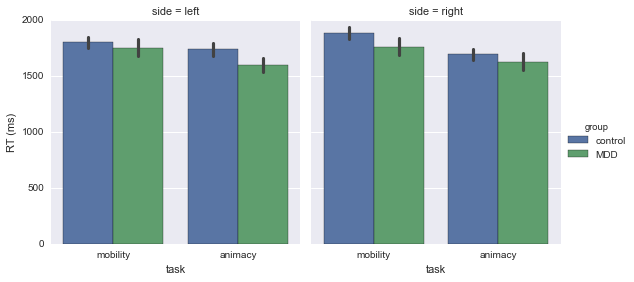

In [152]:
# Interaction seems to reflect a bigger difference in RT by task for MDDs vs. controls on left side vs. right,
# but the GxT is not significant under either side considered separately, see below.

sns.factorplot(y='RT (ms)',x='task',hue='group',col='side',units='subject',ci=68,kind='bar',data=erp_enc_corr)

In [154]:
# Okay, so let's look for Group x Task at each level of Side. Left first; no Group x Task here.

left = erp_enc_corr[erp_enc_corr.side == 'left']

%Rpush left

%R left_rt.aov <- ezANOVA(dv=RT, wid=subject, within=task, between=group, data=left)
%R print(left_rt.aov)

$ANOVA
      Effect DFn DFd         F            p p<.05         ges
2      group   1  44  1.566831 2.172816e-01       0.031585039
3       task   1  44 22.574689 2.182309e-05     * 0.041361303
4 group:task   1  44  3.680605 6.155159e-02       0.006985417



In [155]:
# Now right . . . no significant Group x Task here either.

right = erp_enc_corr[erp_enc_corr.side == 'right']

%Rpush right

%R right_rt.aov <- ezANOVA(dv=RT, wid=subject, within=task, between=group, data=right)
%R print(right_rt.aov)

$ANOVA
      Effect DFn DFd         F            p p<.05         ges
2      group   1  44  1.242841 2.709765e-01       0.025738341
3       task   1  44 50.232695 8.510457e-09     * 0.068803320
4 group:task   1  44  1.222999 2.747830e-01       0.001795673



**Summary:** at encoding, everyone is slower and less accurate for mobility vs. animacy judgments. There are no reliable group differences, but if anything, the MDD group is a little quicker.

## Retrieval

In [156]:
# Response options:
# 'Question': 1 = sure living/non-living, 2 = prob living/non-living, 4 = prob mobile/immobile, 5 = sure mob/immob
# 'Side': 1 = sure left, 2 = prob left, 4 = prob right, 5 = sure right
# 'Odd_even': 1 = sure odd, 2 = prob odd, 4 = prob even, 5 = sure even
# 3 = guess for all prompts

# Conditions:
# 1 = left/living_non-living
# 2 = right/living_non-living
# 3 = left/mobile_immobile
# 4 = right/mobile_immobile

def CompAcc(trialtype):
    
    prompt, condition, response = trialtype
    
    CondDict = {1 : 'left/living_non-living', 2 : 'right/living_non-living',
                3 : 'left/mobile_immobile', 4 : 'right/mobile_immobile',
                5 : 'odd', 6 : 'even'}
    
    RespDicts = {'Question' : {1 : 'living_non-living', 2 : 'living_non-living', 3 : 'guess',
                                4 : 'mobile_immobile', 5 : 'mobile_immobile', 999 : 'no_response'},
                'Side' : {1 : 'left', 2 : 'left', 3 : 'guess', 4 : 'right', 5 : 'right', 999 : 'no_response'},
                'Odd_even' : {1 : 'odd', 2 : 'odd', 3 : 'guess', 4 : 'even', 5 : 'even', 999 : 'no_response'}}
    
    if response == 1 or response == 5:
        Confidence = 'high'
    elif response == 2 or response == 4:
        Confidence = 'low'
    elif response == 3 or response == 999:
        Accuracy = np.nan
        Confidence = np.nan 
        
    CurrCond = CondDict[condition]
    CurrResp = RespDicts[prompt][response]
    
    if '/' in CurrCond:
        ActualSide = CurrCond.split('/')[0]
        ActualTask = CurrCond.split('/')[1]
    
    else:
        Parity = CurrCond
          
    if CurrResp != 'guess' and CurrResp != 'no_response':
        if prompt == 'Odd_even':
            if Parity == CurrResp:
                Accuracy = 1
            elif Parity != CurrResp:
                Accuracy = 0
    
        elif prompt == 'Question' and ActualTask == CurrResp:
            Accuracy = 1

        elif prompt == 'Question' and ActualTask != CurrResp:
            Accuracy = 0

        elif prompt == 'Side' and ActualSide == CurrResp:
            Accuracy = 1

        elif prompt == 'Side' and ActualSide != CurrResp:
            Accuracy = 0

    return (Accuracy,Confidence)

In [157]:
# Assemble the retrieval dataframe.
%cd {path2data}
subjects = !ls -d SM0*

r_dfs = []
rf_d = re.compile('Source_ret')

for subject in subjects:
    curr_path = path2data + subject
    for root, dirs, files in os.walk(curr_path):
        for filename in files:
            rf_m = rf_d.search(filename)
            if rf_m:
                file_path = curr_path + '/CSV/' + filename
                r_df = pd.read_csv(file_path)
                r_df['subject'] = subject
                r_dfs.append(r_df)
                
ret_data = pd.concat(r_dfs)
ret_data.RT = ret_data.RT.map(lambda x: np.nan if x <0 else x) # 45 and 46 are still in, but dropna will remove them

# Code accuracy
ret_data['accuracy'], ret_data['confidence'] = zip(*ret_data[['prompt','condition','response']].apply(CompAcc, axis=1))

# Mark outliers, mean +/- 3SDs
dfs = []
for sub in ret_data.subject.unique():
    outlier = []
    df = ret_data[ret_data.subject == sub]
    for i, row_i in df.iterrows():
        if np.isnan(row_i.RT):
            outlier.append(np.nan)
        elif abs(row_i.RT-df.RT.mean()) <= df.RT.std()*3:
            outlier.append(0)
        else:
            outlier.append(1)
    df['outlier'] = outlier
    dfs.append(df)
ret = pd.concat(dfs)

print "Number of retrieval trials that are not (0) outliers vs. are (1) outliers:"
print ret.outlier.value_counts()

# Count number of trials with no response, drop them, and drop outliers.
print "Number of retrieval trials with no response: " + str(len(ret[ret.RT == 999])) 
ret_clean = ret[~((ret.RT == 999) | (ret.outlier == 1))]

ret_clean.to_csv(path2analysis + 'ret_clean.csv',index=False)

/Users/ebarrick/Work/Expts/SOURCE/Data
Number of retrieval trials that are not (0) outliers vs. are (1) outliers:
0    16711
1      281
dtype: int64
Number of retrieval trials with no response: 10


/Users/ebarrick/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


In [158]:
# Merge the retrieval and self-report data
ret = pd.merge(ret_clean,sr,on='subject')
ret = ret[~(ret.Inclusion == 0)] # Drop subjects who should be excluded based on MINI

# Fix dtype issues
del ret['Notes']
ret.Group = ret.Group.astype(int)
ret.Gender = ret.Gender.astype(str)
ret.Race = ret.Race.astype(str)
ret['Highest Degree'] = ret['Highest Degree'].astype(str)
ret.Occupation = ret.Occupation.astype(str)
ret.Income = ret.Income.astype(str)
ret.Inclusion = ret.Inclusion.astype(int)
ret.confidence = ret.confidence.astype(str)

# Rename a couple things
ret.rename(columns={'Group':'group','Gender':'gender','prompt':'cue'},inplace=True)

# Add guesses
ret['guess'] = ret.response.map(lambda x: 1 if x == 3 else 0)

# Go with group names rather than numbers
ret.group = ret.group.replace(to_replace={0:'control',1:'MDD'})

# And grab just those subjects with clean ERP data
erp_ret = ret[ret.subject.isin(erpSubs_all)]

In [159]:
# We need to know which words were encoded on the left vs. right and with what question. 
# This information is contained in "condition" but let's make columns with more obvious names.

def EncodingCondition(value):

    CondDict = {1 : 'left/living_non-living', 2 : 'right/living_non-living',
                3 : 'left/mobile_immobile', 4 : 'right/mobile_immobile'}
    
    if value == 5 or value == 6: # These are odd/even trials
        side = 'none'
        question = 'none'
    else:
        condition = CondDict[value]
        side = condition.split('/')[0]
        question = condition.split('/')[1]
        if question == 'living_non-living':
            question = 'animacy'
        elif question == 'mobile_immobile':
            question = 'mobility'
    
    return (side, question)

erp_ret['encoding_location'],erp_ret['encoding_task'] = zip(*erp_ret.condition.map(EncodingCondition))

/Users/ebarrick/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


In [160]:
erp_ret.groupby('group')['subject'].nunique()

group
MDD        24
control    24
Name: subject, dtype: int64

### Guesses 

IGD pointed to the guesses and wants to know if there are group differences there. Let's look at that again here. Guesses were response 3, which yielded accuracy = 999.

In [161]:
# First, let's see how many people there are with no guesses. We can do that by subtracting out the number of people
# with guesses . . . 
guess = erp_ret[erp_ret.response == 3]
g = guess.groupby(['subject','group','cue','encoding_task'])['response'].value_counts()
df = g.to_frame()
df.reset_index(inplace=True)
cols = ['subject','group','cue','encoding_task','response','count']
df.columns = cols
df = df[['subject','group','cue','encoding_task','count']]
df.head()

,subject,group,cue,encoding_task,count
0,SM011,control,Question,mobility,1
1,SM011,control,Side,mobility,1
2,SM013,control,Question,animacy,5
3,SM013,control,Question,mobility,2
4,SM013,control,Side,animacy,5


In [162]:
# Since this df is based on the erp_ret trials where the response was guess, the fact that there are no Odd/Even cues
# implies that nobody ever guessed on Odd/Even trials. Here are two ways to confirm that . . . 
print df.cue.unique()

s_guess = 0
q_guess = 0
n_guess = 0

for i, row_i in erp_ret.iterrows():
    if row_i.response == 3 and row_i.cue == 'Side':
        s_guess = s_guess + 1
    elif row_i.response == 3 and row_i.cue == 'Question':
        q_guess = q_guess + 1
    elif row_i.response == 3 and row_i.cue == 'Odd_even':
        n_guess = n_guess + 1

print 'The number of Side guesses = ' + str(s_guess)
print 'The number of Question guesses = ' + str(q_guess)
print 'The number of Odd/Even guesses = ' + str(n_guess)

['Question' 'Side']
The number of Side guesses = 523
The number of Question guesses = 358
The number of Odd/Even guesses = 0


In [163]:
# Okay, since the df above only holds data for people who've guessed, let's use that to figure out who never guessed.
# Since there are 24 people per group, this implies that 3 controls and 2 MDDs never guessed.
df.groupby('group')['subject'].nunique()

group
MDD        22
control    21
Name: subject, dtype: int64

In [164]:
# For the ANOVA, we're going to need a df that includes only subjects who guessed at least once for each task and cue.
# Also, get a count of subjects who did not guess in at least one of the four conditions defined by (Cue x Task). 

mdd_ct = 0
hc_ct = 0
no_guesses = []

for sub in df.subject.unique():
    num = int(df[df.subject == sub]['subject'].value_counts())
    if num != 4: # There are 4 conditions (2 Cues x 2 Task) and we're looking for people who don't have all 4
        sdf = df[df.subject == sub]
        sdf.reset_index(inplace=True,drop=True)
        group = sdf.group.ix[0]
        if group == 'control':
            hc_ct = hc_ct + 1
        elif group == 'MDD':
            mdd_ct = mdd_ct + 1
        no_guesses.append(sub)
print "There are " + str(hc_ct) + " controls and " + str(mdd_ct) + " depressed adults who did not guess in response \
to the Question or the Side cue, or both."

nog = df[df['subject'].isin(no_guesses)]
nog['count'].describe() # Shows that the people who did not guess in at least one condition did not guess much overall.

There are 10 controls and 5 depressed adults who did not guess in response to the Question or the Side cue, or both.


count    36.000000
mean      3.500000
std       3.459975
min       1.000000
25%       1.000000
50%       2.000000
75%       5.000000
max      14.000000
Name: count, dtype: float64

Putting together the 3 controls who never guessed and the 10 controls who did not guess in at least 1 condition, we have 11 controls with guesses in all 4 conditions (Cue x Task). For the MDDs, there were 2 who never guessed and 5 who did not guess in at least 1 condition, which leaves 17 who guessed at least once in all 4 conditions. So we're going to be graphing and running ANOVAs on guess data from HC = 11 and MDD = 17.

In [165]:
df.head()

,subject,group,cue,encoding_task,count
0,SM011,control,Question,mobility,1
1,SM011,control,Side,mobility,1
2,SM013,control,Question,animacy,5
3,SM013,control,Question,mobility,2
4,SM013,control,Side,animacy,5


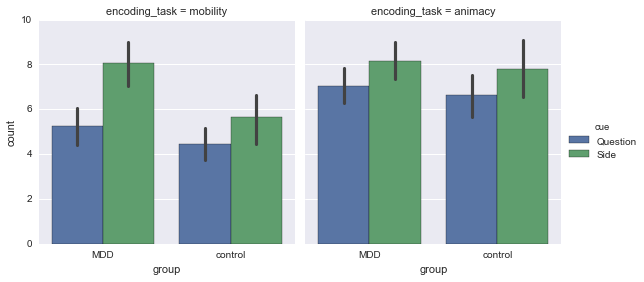

In [166]:
# Now plot the guess data, excluding the subjects with no guesses in one more more condition
# So looks like the MDDs guess more, everybody guesses more under Side vs. Question
df = df[~(df['subject'].isin(no_guesses))]
sns.factorplot(y='count',x='group',hue='cue',col='encoding_task',units='subject',ci=68,kind='bar',data=df,
              order = ['MDD','control'], col_order=['mobility','animacy'])
sns.plt.savefig(path2figs + 'Guessing_GxCxT.pdf')

In [167]:
# Let's get the descriptives there in case we want to use a table instead of a graph
print df.groupby(['group','cue','encoding_task'])['count'].mean()
print df.groupby(['group','cue','encoding_task'])['count'].std()

group    cue       encoding_task
MDD      Question  animacy          7.058824
                   mobility         5.235294
         Side      animacy          8.176471
                   mobility         8.058824
control  Question  animacy          6.636364
                   mobility         4.454545
         Side      animacy          7.818182
                   mobility         5.636364
Name: count, dtype: float64
group    cue       encoding_task
MDD      Question  animacy          3.381394
                   mobility         3.363953
         Side      animacy          3.450277
                   mobility         4.436646
control  Question  animacy          3.294624
                   mobility         2.583162
         Side      animacy          4.400413
                   mobility         4.006812
Name: count, dtype: float64


In [168]:
# ANOVA on guesses; effects of Cue and Task, people guessed more in to Side vs. Question and for Animacy vs. Mobility.
# No effect of Group, no interactions.

%Rpush df
# %R str(df)

%R guess.aov <- ezANOVA(dv=count, wid=subject, within=.(cue,encoding_task), between=group, data=df)
%R print(guess.aov)

$ANOVA
                   Effect DFn DFd          F           p p<.05         ges
2                   group   1  26  0.7479166 0.395046059       0.018592008
3                     cue   1  26  8.2669324 0.007950142     * 0.052316078
5           encoding_task   1  26 10.8891916 0.002809452     * 0.040193826
4               group:cue   1  26  0.4448165 0.510682896       0.002961557
6     group:encoding_task   1  26  1.8212954 0.188793793       0.006955515
7       cue:encoding_task   1  26  2.0576233 0.163365674       0.005339207
8 group:cue:encoding_task   1  26  1.3314033 0.259052481       0.003461304



In [169]:
# Give me descriptives for the main effect of Cue
print df.groupby('cue')['count'].mean()
print df.groupby('cue')['count'].std()

cue
Question    5.910714
Side        7.571429
Name: count, dtype: float64
cue
Question    3.298908
Side        4.071440
Name: count, dtype: float64


In [170]:
# Now descriptives for the main effect of Task
print df.groupby('encoding_task')['count'].mean()
print df.groupby('encoding_task')['count'].std()

encoding_task
animacy     7.464286
mobility    6.017857
Name: count, dtype: float64
encoding_task
animacy     3.557140
mobility    3.891674
Name: count, dtype: float64


So the **bottom line for guesses** is that everyone guessed more in response to Side versus Question cue and in response to words from the animacy vs. mobility task, but there are no group differences.

### Accuracy 

#### Odd/Even 

We are ultimately going to want to run Group x Cue x Task, and since there is no Task when Cue == Odd_even, we're going to have to drop the Odd/Even trials from the analysis. But first let's look at the accuracy data from those trials, to see whether there are any group differences.

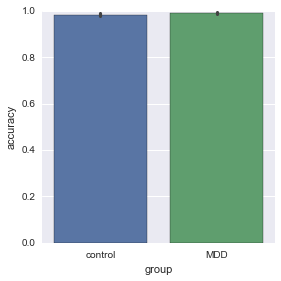

In [171]:
# Shows that both groups are extremely accurate on Odd/Even trials 
oe = erp_ret[erp_ret.cue == 'Odd_even']
sns.factorplot(y='accuracy',x='group',units='subject',ci=68,kind='bar',data=oe)

In [172]:
# T-test on the group difference in accuracy on Odd/Even trials, no difference.
g = oe.groupby(['group','subject'])['accuracy'].mean()
df = g.to_frame()
df.reset_index(inplace=True)
print 100*(df.groupby('group')['accuracy'].mean())
print 100*(df.groupby('group')['accuracy'].std())
misc.ttest_2s(df[df.group == 'control']['accuracy'],df[df.group == 'MDD']['accuracy'])

group
MDD        99.131944
control    98.423784
Name: accuracy, dtype: float64
group
MDD        1.362214
control    3.963357
Name: accuracy, dtype: float64
t(46) = -0.83, p = 0.412


(-0.8278041907455097, 0.41205557739647902)

#### Group x Cue x Task 

Okay, for the rest of the accuracy analysis we want to exclude the Odd/Even trials. So let's set up a df without those.

In [173]:
noe = erp_ret[~(erp_ret.cue == 'Odd_even')]
noe.reset_index(inplace = True,drop=True)
noe.head()

,subject,run,trial,cue,item,condition,response,RT,iti_dur(ms),accuracy,...,PSQI_Latency,PSQI_DayDys,PSQI_Efficiency,PSQI_Quality,PSQI_Medication,WTAR_NatEng,WTAR_StdScore,guess,encoding_location,encoding_task
0,SM011,1,2,Question,desk,4,1,3.201,501,0,...,0,0,0,0,0,yes,89,0,right,mobility
1,SM011,1,3,Question,fern,1,1,0.784,501,1,...,0,0,0,0,0,yes,89,0,left,animacy
2,SM011,1,5,Question,balloon,2,1,1.067,1002,1,...,0,0,0,0,0,yes,89,0,right,animacy
3,SM011,1,7,Question,pine,4,1,0.567,2004,0,...,0,0,0,0,0,yes,89,0,right,mobility
4,SM011,1,8,Question,sparrow,3,1,0.850,1002,0,...,0,0,0,0,0,yes,89,0,left,mobility


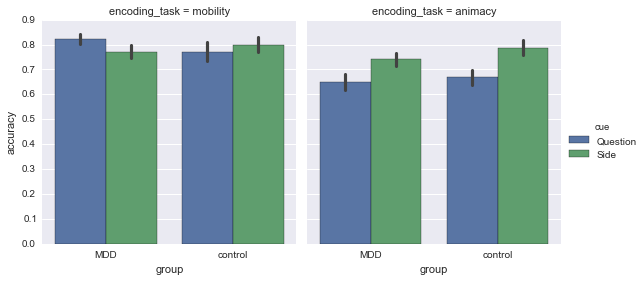

In [174]:
# I think this is a good way to plot the data b/c it highlights the gorup difference in the cue effect for words from
# the mobility task. 
sns.set_style('darkgrid')
sns.factorplot(y='accuracy',x='group',hue='cue',col='encoding_task',units='subject',ci=68,kind='bar',data=noe,
              order = ['MDD','control'])
sns.plt.savefig(path2figs + 'Ret_Acc_GxCxT.pdf')

In [175]:
# For guesses, response == 3 and accuracy == NaN. 
# We don't want to analyze those trials and ez will complain about them. Let's drop.
# End up with effects of Cue and Task, plus Group x Cue and Cue x Task interactions. 
# Initially I followed up the interactions, but I think I would recommend going straight to the Group x Cue ANOVAs,
# separately by task. Or you could start with that--rather than Group x Cue x Task, you could do two Group x Cues.
# That might be too cheesy and it'd mean all the other ANOVAs would have to be done that way too . . . 

noe_nog = noe[~(noe.response == 3)]
%Rpush noe_nog
# %R str(noe)

%R ret_acc <- ezANOVA(dv=accuracy, wid=subject, within=.(cue,encoding_task), between=group, data=noe_nog)
%R print(ret_acc)

$ANOVA
                   Effect DFn DFd          F            p p<.05         ges
2                   group   1  46  0.1162829 7.346542e-01       0.001695008
3                     cue   1  46 17.4695553 1.292625e-04     * 0.032951144
5           encoding_task   1  46 31.9513678 9.575239e-07     * 0.085567263
4               group:cue   1  46  6.4161901 1.478263e-02     * 0.012359934
6     group:encoding_task   1  46  2.4375720 1.253137e-01       0.007088177
7       cue:encoding_task   1  46 22.3489956 2.180290e-05     * 0.048053265
8 group:cue:encoding_task   1  46  0.8438853 3.630799e-01       0.001902430



In [176]:
# BP Reviewer 1 asked if the results still hold when including IQ or Education as covariates. Let's see . . . 
# adding Education makes no difference, but with WTAR in there the Group x Cue is n.s., although WTAR x G x C is sig.
# This is fine but actually the Group x Cue for mobility trials is probably more important, let's check that too.

%R library('afex') # ezANOVA doesn't play nice with covariates but this one does, let's use it going forward

%R ret_acc_afex <- aov_ez(id='subject', dv='accuracy', data=noe_nog, between='group', within=c('cue','encoding_task'))

%R ret_acc_educ <- aov_ez(id='subject', dv='accuracy', data=noe_nog, between='group', within=c('cue','encoding_task'),\
                  covariate=c('Education_Years'))

noe_nog_wtar = noe_nog[noe_nog.WTAR_NatEng=='yes']
%Rpush noe_nog_wtar

%R ret_acc_wtar <- aov_ez(id='subject', dv='accuracy', data=noe_nog_wtar, between='group',\
                          within=c('cue','encoding_task'),covariate=c('WTAR_StdScore'))
                   
%R print(ret_acc_afex)
%R print(ret_acc_educ)
%R print(ret_acc_wtar)

                   Effect    df  MSE         F  ges p.value
1                   group 1, 46 0.05      0.12 .002     .73
2                     cue 1, 46 0.01 17.47 ***  .03   .0001
3               group:cue 1, 46 0.01    6.42 *  .01     .01
4           encoding_task 1, 46 0.01 31.95 ***  .09  <.0001
5     group:encoding_task 1, 46 0.01      2.44 .007     .13
6       cue:encoding_task 1, 46 0.01 22.35 ***  .05  <.0001
7 group:cue:encoding_task 1, 46 0.01      0.84 .002     .36


                              Effect     df  MSE      F  ges p.value
1                              group  1, 36 0.04   0.08 .001     .78
2                    Education_Years 10, 36 0.04 2.09 +  .27     .05
3                                cue  1, 36 0.01 5.66 *  .02     .02
4                          group:cue  1, 36 0.01 4.42 *  .01     .04
5                Education_Years:cue 10, 36 0.01   0.43  .01     .92
6                      encoding_task  1, 36 0.01 6.61 *  .03     .01
7                group:encoding_task  1, 36 0.01 6.38 *  .02     .02
8      Education_Years:encoding_task 10, 36 0.01   1.48  .05     .19
9                  cue:encoding_task  1, 36 0.01 3.77 +  .01     .06
10           group:cue:encoding_task  1, 36 0.01 3.46 +  .01     .07
11 Education_Years:cue:encoding_task 10, 36 0.01   1.19  .04     .33


                            Effect     df  MSE         F    ges p.value
1                            group  1, 23 0.04      0.60    .02     .45
2                    WTAR_StdScore 19, 23 0.04      1.34    .43     .25
3                              cue  1, 23 0.01   7.99 **    .03    .010
4                        group:cue  1, 23 0.01      0.88   .004     .36
5                WTAR_StdScore:cue 19, 23 0.01      1.05    .08     .45
6                    encoding_task  1, 23 0.01 14.30 ***    .09   .0010
7              group:encoding_task  1, 23 0.01      0.00 <.0001    >.99
8      WTAR_StdScore:encoding_task 19, 23 0.01      1.10    .12     .41
9                cue:encoding_task  1, 23 0.01  13.61 **    .05    .001
10         group:cue:encoding_task  1, 23 0.01      1.30   .005     .27
11 WTAR_StdScore:cue:encoding_task 19, 23 0.01    2.08 *    .12     .05


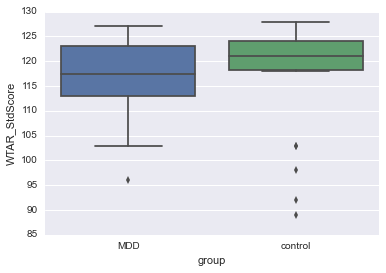

In [177]:
g = noe_nog_wtar.groupby(['group','subject'])['WTAR_StdScore'].mean()
df = g.to_frame()
df.reset_index(inplace=True)
df.head()
sns.boxplot(y='WTAR_StdScore',x='group',data=df)

In [178]:
# To follow-up the Group x Cue, we can just run b/w group t-tests at each level of Cue.
# Neither one is significant, but looking at the t values you can see why there is an interaction: 
# it's MDD > HC under Question but MDD < HC under Side.

g = noe_nog.groupby(['subject','group','cue'])['accuracy'].mean()
df = g.to_frame()
df.reset_index(inplace=True)

print 'Group difference under Question:'
misc.ttest_2s(df[(df.group == 'control') & (df.cue == 'Question')]['accuracy'],
              df[(df.group == 'MDD') & (df.cue == 'Question')]['accuracy'])
print '\nGroup difference under Side:'
misc.ttest_2s(df[(df.group == 'control') & (df.cue == 'Side')]['accuracy'],
              df[(df.group == 'MDD') & (df.cue == 'Side')]['accuracy'])

Group difference under Question:
t(46) = -0.57, p = 0.575

Group difference under Side:
t(46) = 1.19, p = 0.242


(1.1858011203853369, 0.24179010619890151)

In [179]:
# Here are the descriptives . . the group differences are pretty modest . . . 
print 100*(df.groupby(['group','cue'])['accuracy'].mean())
print '\n'
print 100*(df.groupby(['group','cue'])['accuracy'].std())

group    cue     
MDD      Question    73.882341
         Side        75.534648
control  Question    72.031600
         Side        79.471551
Name: accuracy, dtype: float64


group    cue     
MDD      Question     9.202547
         Side         9.841238
control  Question    13.136984
         Side        12.949650
Name: accuracy, dtype: float64


In [180]:
# To follow-up the Cue x Task, we can collapse over group and run b/w Task comparisons under each Cue.
# No surprise here, big Task effect (mobility > animacy) under Question but not Side . . .

g = noe_nog.groupby(['subject','cue','encoding_task'])['accuracy'].mean()
df = g.to_frame()
df.reset_index(inplace=True)
df.head()

print 'Task difference under Question:'
misc.ttest_2s(df[(df.encoding_task == 'mobility') & (df.cue == 'Question')]['accuracy'],
              df[(df.encoding_task == 'animacy') & (df.cue == 'Question')]['accuracy'])
print '\nTask difference under Side:'
misc.ttest_2s(df[(df.encoding_task == 'mobility') & (df.cue == 'Side')]['accuracy'],
              df[(df.encoding_task == 'animacy') & (df.cue == 'Side')]['accuracy'])

Task difference under Question:
t(94) = 4.75, p = 0.000

Task difference under Side:
t(94) = 0.84, p = 0.402


(0.84211437083819451, 0.4018613871872595)

In [181]:
# The other way to follow-up the Cue x Task is to collapse over group and run b/w Cue comparisons for each Task.
# As with the second method of plotting the accuracy data, this is probably better b/c done this way you have the 
# Cue effect when the words/task are being held constant (cleaner look at the retrieval effects).

# And what you find is a big Cue effect for words from the animacy task, no effect at all for words from mobility.

g = noe_nog.groupby(['subject','cue','encoding_task'])['accuracy'].mean()
df = g.to_frame()
df.reset_index(inplace=True)
df.head()

print 'Cue effect for words from the mobility task:'
misc.ttest_2s(df[(df.encoding_task == 'mobility') & (df.cue == 'Question')]['accuracy'],
              df[(df.encoding_task == 'mobility') & (df.cue == 'Side')]['accuracy'])
print '\nCue effect for words from the animacy task:'
misc.ttest_2s(df[(df.encoding_task == 'animacy') & (df.cue == 'Question')]['accuracy'],
              df[(df.encoding_task == 'animacy') & (df.cue == 'Side')]['accuracy'])

Cue effect for words from the mobility task:
t(94) = 0.38, p = 0.703

Cue effect for words from the animacy task:
t(94) = -3.95, p = 0.000


(-3.9457117875528387, 0.00015334692134536288)

Of course the stinker here is there is no 3-way interaction. What if you look for Group x Cue only under for words from mobility?

In [182]:
# If you look only at data from the mobility task, you get a strong Group x Cue interaction, F > 6.3, p = 0.01.
# No Cue effect here, F < 1.

noe_nog_MI = noe_nog[noe_nog.encoding_task == 'mobility']
%Rpush noe_nog_MI

%R ret_acc_MI <- ezANOVA(dv=accuracy, wid=subject, within=cue, between=group, data=noe_nog_MI)
%R print(ret_acc_MI)

$ANOVA
     Effect DFn DFd         F          p p<.05         ges
2     group   1  46 0.1030273 0.74968041       0.001853273
3       cue   1  46 0.4282893 0.51608849       0.001589656
4 group:cue   1  46 6.4477479 0.01455471     * 0.023408729



In [183]:
# Make sure you don't get Group x Cue for animacy. No, F < 1; just a strong Cue effect (F > 35).
noe_nog_LNL = noe_nog[noe_nog.encoding_task == 'animacy']
%Rpush noe_nog_LNL

%R ret_acc_LNL <- ezANOVA(dv=accuracy, wid=subject, within=cue, between=group, data=noe_nog_LNL)
%R print(ret_acc_LNL)

$ANOVA
     Effect DFn DFd          F            p p<.05         ges
2     group   1  46  0.9363400 3.382812e-01       0.015694990
3       cue   1  46 35.8917049 2.987450e-07     * 0.144599069
4 group:cue   1  46  0.9969703 3.232683e-01       0.004673578



In [184]:
# Here are the descriptives. 14% difference b/w tasks under Question, 3% under Side.

print 100*(df.groupby(['cue','encoding_task'])['accuracy'].mean())
print '\n'
print 100*(df.groupby(['cue','encoding_task'])['accuracy'].std())

cue       encoding_task
Question  animacy          65.923338
          mobility         79.553235
Side      animacy          76.436967
          mobility         78.523520
Name: accuracy, dtype: float64


cue       encoding_task
Question  animacy          14.180475
          mobility         13.923627
Side      animacy          11.819947
          mobility         12.448846
Name: accuracy, dtype: float64


In [185]:
# Okay, now compute the Q-S difference scores for mobility
noe_nog_MI.head()
g = noe_nog_MI.groupby(['subject','group','cue'])['accuracy'].mean()
df = g.to_frame()
df.reset_index(inplace=True)
table_MI = df.pivot_table(index=['subject','group'],columns='cue',values='accuracy')
table_MI.reset_index(inplace=True)
new_cols = ['subject','group','Question','Side']
table_MI.columns = new_cols
table_MI['Q-S'] = table_MI['Question']-table_MI['Side']
table_MI['condition'] = 'mobility'
table_MI.head()

,subject,group,Question,Side,Q-S,condition
0,SM011,control,0.304348,0.434783,-0.130435,mobility
1,SM013,control,0.717391,0.700000,0.017391,mobility
2,SM014,control,0.744186,0.869565,-0.125379,mobility
3,SM015,MDD,0.765957,0.541667,0.224291,mobility
4,SM017,control,0.854167,0.860465,-0.006298,mobility


In [186]:
# Give me descriptives and the b/w groups t-test
print 100*(table_MI.groupby('group')['Q-S'].mean())
print 100*(table_MI.groupby('group')['Q-S'].std())
misc.ttest_2s(table_MI[table_MI.group == 'MDD']['Q-S'],
             table_MI[table_MI.group == 'control']['Q-S'])

group
MDD        5.025046
control   -2.965615
Name: Q-S, dtype: float64
group
MDD        11.949340
control     9.740642
Name: Q-S, dtype: float64
t(46) = 2.54, p = 0.015


(2.5392415907979102, 0.014554707420496868)

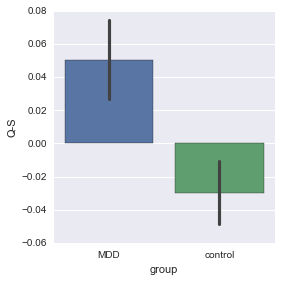

In [187]:
# And plot it . . . 
sns.factorplot(y='Q-S',x='group',units='subject',ci=68,kind='bar',data=table_MI,
              order = ['MDD','control'])
sns.plt.savefig(path2figs + 'QvS_MI.pdf')

In [188]:
# Now compute the Q-S difference scores for animacy

g = noe_nog_LNL.groupby(['subject','group','cue'])['accuracy'].mean()
df = g.to_frame()
df.reset_index(inplace=True)
table_LNL = df.pivot_table(index=['subject','group'],columns='cue',values='accuracy')
table_LNL.reset_index(inplace=True)
new_cols = ['subject','group','Question','Side']
table_LNL.columns = new_cols
table_LNL['Q-S'] = table_LNL['Question']-table_LNL['Side']
table_LNL['condition'] = 'animacy'
table_LNL.head()

,subject,group,Question,Side,Q-S,condition
0,SM011,control,0.702128,0.437500,0.264628,animacy
1,SM013,control,0.476190,0.790698,-0.314507,animacy
2,SM014,control,0.723404,0.941176,-0.217772,animacy
3,SM015,MDD,0.413043,0.541667,-0.128623,animacy
4,SM017,control,0.652174,0.780488,-0.128314,animacy


In [189]:
# Give me descriptives and the b/w groups t-test
print 100*(table_LNL.groupby('group')['Q-S'].mean())
print 100*(table_LNL.groupby('group')['Q-S'].std())
misc.ttest_2s(table_LNL[table_LNL.group == 'MDD']['Q-S'],
             table_LNL[table_LNL.group == 'control']['Q-S'])

group
MDD        -8.761376
control   -12.265881
Name: Q-S, dtype: float64
group
MDD         9.822191
control    14.113031
Name: Q-S, dtype: float64
t(46) = 1.00, p = 0.323


(0.99848401851382407, 0.32326834362609924)

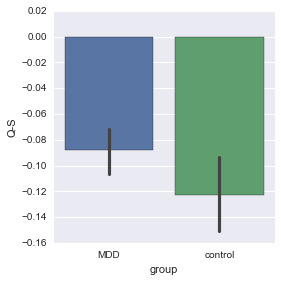

In [190]:
# And plot it . . . 
sns.factorplot(y='Q-S',x='group',units='subject',ci=68,kind='bar',data=table_LNL,
              order = ['MDD','control'])
sns.plt.savefig(path2figs + 'QvS_LNL.pdf')

In [191]:
# Need to concat tables for w/in group t-tests
both = pd.concat([table_MI,table_LNL])
both.head()

print 'MDD . . . '
misc.ttest_2s(both[(both.group == 'MDD') & (both.condition == 'mobility')]['Q-S'],
             both[(both.group == 'MDD') & (both.condition == 'animacy')]['Q-S'],
             paired=True)

print 'controls . . . '
misc.ttest_2s(both[(both.group == 'control') & (both.condition == 'mobility')]['Q-S'],
             both[(both.group == 'control') & (both.condition == 'animacy')]['Q-S'],
             paired=True)

MDD . . . 
t(23) = 3.82, p = 0.001
controls . . . 
t(23) = 2.83, p = 0.010


(2.8283273839001555, 0.0095281927944516273)

In [192]:
# Any chance you get a sig b/w group diff for Q/MI? Nope
misc.ttest_2s(both[(both.group == 'MDD') & (both.condition == 'mobility')]['Question'],
             both[(both.group == 'control') & (both.condition == 'mobility')]['Question'])

t(46) = 1.28, p = 0.207


(1.2792348461266727, 0.20722975813559297)

In [193]:
# In response to BP Reviewer 1, let's repeat the Group x Cue under mobility with education and WTAR as covs to see
# if they matter. Education does not matter but WTAR is significant and there is a Cue x WTAR interaction that
# renders the Group x Cue effect n.s.

noe_nog_MI_wtar = noe_nog_MI[noe_nog_MI.WTAR_NatEng == 'yes']
%Rpush noe_nog_MI_wtar

%R ret_acc_MI_afex <- aov_ez(id='subject', dv='accuracy', data=noe_nog_MI, between='group', within='cue')

%R ret_acc_MI_educ <- aov_ez(id='subject', dv='accuracy', data=noe_nog_MI, between='group',\
                             within='cue', covariate=c('Education_Years'))

%R ret_acc_MI_wtar <- aov_ez(id='subject', dv='accuracy', data=noe_nog_MI_wtar, between='group',\
                             within='cue',covariate=c('WTAR_StdScore'))

%R print(ret_acc_MI_afex)
%R print(ret_acc_MI_educ)
%R print(ret_acc_MI_wtar)

     Effect    df  MSE      F  ges p.value
1     group 1, 46 0.03   0.10 .002     .75
2       cue 1, 46 0.01   0.43 .002     .52
3 group:cue 1, 46 0.01 6.45 *  .02     .01


               Effect     df  MSE       F   ges p.value
1               group  1, 36 0.02    1.66   .04     .21
2     Education_Years 10, 36 0.02  1.84 +   .29     .09
3                 cue  1, 36 0.01    0.12 .0007     .74
4           group:cue  1, 36 0.01 8.39 **   .05    .006
5 Education_Years:cue 10, 36 0.01    0.59   .03     .81


             Effect     df  MSE      F    ges p.value
1             group  1, 23 0.02   0.66    .02     .43
2     WTAR_StdScore 19, 23 0.02 2.32 *    .62     .03
3               cue  1, 23 0.00   0.28   .002     .60
4         group:cue  1, 23 0.00   0.01 <.0001     .92
5 WTAR_StdScore:cue 19, 23 0.00 2.79 *    .26     .01


In [194]:
noe_nog_MI_wtar.WTAR_StdScore.describe()

count    3792.000000
mean      116.829905
std         9.784776
min        89.000000
25%       113.000000
50%       120.000000
75%       124.000000
max       128.000000
Name: WTAR_StdScore, dtype: float64

In [195]:
def MedSplit(wtar):
    '''Based on the descriptive data, I am running a median split on WTAR scores to ease the graphing.'''
    if wtar < 120:
        out = 'low'
    elif wtar > 120:
        out = 'high'
    elif wtar == 120:
        out = np.nan
        
    return out

/Users/ebarrick/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  from ipykernel import kernelapp as app


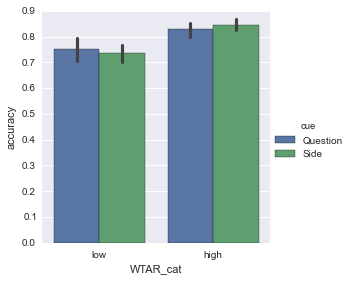

In [196]:

noe_nog_MI_wtar['WTAR_cat'] = noe_nog_MI_wtar.WTAR_StdScore.apply(MedSplit)
# g = sns.factorplot(y='accuracy',x='WTAR_StdScore',hue='cue',ci=68,kind='bar',data=noe_nog_MI_wtar)
# g.set_xticklabels(rotation=90)
sns.factorplot(y='accuracy',x='WTAR_cat',hue='cue',units='subject',ci=68,kind='bar',data=noe_nog_MI_wtar)

In [197]:
table_MI.head()

,subject,group,Question,Side,Q-S,condition
0,SM011,control,0.304348,0.434783,-0.130435,mobility
1,SM013,control,0.717391,0.700000,0.017391,mobility
2,SM014,control,0.744186,0.869565,-0.125379,mobility
3,SM015,MDD,0.765957,0.541667,0.224291,mobility
4,SM017,control,0.854167,0.860465,-0.006298,mobility


In [198]:
wtar_native = []
wtar_StdScore = []
for i, row_i in table_MI.iterrows():
    wtar_native.append(noe_nog[noe_nog.subject == row_i.subject].WTAR_NatEng.unique()[0])
    wtar_StdScore.append(noe_nog[noe_nog.subject == row_i.subject].WTAR_StdScore.unique()[0])
table_MI['WTAR_NatEng'] = wtar_native
table_MI['WTAR_StdScore'] = wtar_StdScore
table_MI_wtar = table_MI[table_MI.WTAR_NatEng == 'yes']
table_MI_wtar.sort_values('WTAR_StdScore',inplace=True)

AttributeError: 'DataFrame' object has no attribute 'sort_values'

In [ ]:
g = sns.factorplot(y='Q-S',x='subject',data=table_MI_wtar[table_MI_wtar.group == 'MDD'],kind='bar')
g.set_xticklabels(rotation=90)
plt.suptitle('MDD')

g = sns.factorplot(y='Q-S',x='subject',data=table_MI_wtar[table_MI_wtar.group == 'control'],kind='bar')
g.set_xticklabels(rotation=90)
plt.suptitle('controls')

In [ ]:
sns.set_style('white')
sns.set_context('paper')

fig = plt.figure()
ax1 = fig.add_subplot(211)
g = sns.barplot(y='Q-S',x='subject',data=table_MI_wtar[table_MI_wtar.group == 'MDD'],ax=ax1)
g.set_xticklabels(table_MI_wtar[table_MI_wtar.group == 'MDD']['subject'],rotation=90)
h = sns.pointplot(y='WTAR_StdScore',x='subject',data=table_MI_wtar[table_MI_wtar.group == 'MDD'],\
                  join=False,ax=ax1.twinx())

ax2 = fig.add_subplot(212)
g = sns.barplot(y='Q-S',x='subject',data=table_MI_wtar[table_MI_wtar.group == 'control'],ax=ax2)
g.set_xticklabels(table_MI_wtar[table_MI_wtar.group == 'control']['subject'],rotation=90)
h = sns.pointplot(y='WTAR_StdScore',x='subject',data=table_MI_wtar[table_MI_wtar.group == 'control'],\
                  join=False,ax=ax2.twinx())

fig.tight_layout()

In [ ]:
sns.set_style('white')
sns.set_context('paper')

pal_dict = {'control':sns.xkcd_rgb['tan'],'MDD':sns.xkcd_rgb['light blue']}
fig = plt.figure()
ax1 = fig.add_subplot(111)
g = sns.barplot(y='Q-S',x='subject',palette = table_MI_wtar['group'].map(pal_dict),data=table_MI_wtar,ax=ax1)
g.set_xticklabels(table_MI_wtar['subject'],rotation=90)
h = sns.pointplot(y='WTAR_StdScore',x='subject',data=table_MI_wtar,join=False,ax=ax1.twinx())
plt.savefig(path2figs + 'Q-S_by_WTAR.pdf')

In [ ]:
noe_nog_MI_wtar_hc = noe_nog_MI_wtar[noe_nog_MI_wtar.group == 'control']
noe_nog_MI_wtar_hc.sort_values('WTAR_StdScore',inplace=True)

noe_nog_MI_wtar_mdd = noe_nog_MI_wtar[noe_nog_MI_wtar.group == 'MDD']
noe_nog_MI_wtar_mdd.sort_values('WTAR_StdScore',inplace=True)

g = sns.factorplot(y='accuracy',x='subject',hue='cue',ci=68,kind='bar',data=noe_nog_MI_wtar_hc,
                  hue_order=['Question','Side'])
g.set_xticklabels(rotation=90)
plt.suptitle('Controls')

g = sns.factorplot(y='accuracy',x='subject',hue='cue',ci=68,kind='bar',data=noe_nog_MI_wtar_mdd,
                  hue_order=['Question','Side'])
g.set_xticklabels(rotation=90)
plt.suptitle('MDD')

Okay, so the **bottom line** here is we have a Group x Cue effect for words from the mobility task but not the animacy task. For words from both tasks, we isolate the Cue effect by performing Q-S subtractions. For words from the mobility task, that difference score is more positive in MDD vs. HC, but for words from the animacy task, there is no group difference. This indicates that the MDD group was more affected by the cueing manipulation than the HC group for words from the mobility task, with the Qcue supporting the highest level of accuracy in MDD (when paired with words from the mobility task). This is in line with the idea that MDDs do best with deep encoding followed by conceptual retrieval (may be worth re-reading Ed Watkins's work on conceptual implicit retrieval in MDD).

### Correct RT 

#### Odd/Even 

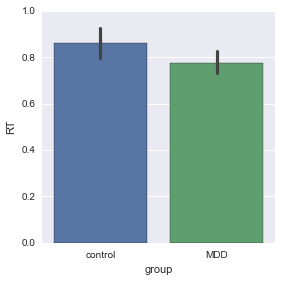

In [199]:
# Shows that on Odd/Even trials, the MDDs are actually a bit faster than the controls. No psychomotor slowing here!
oe_corr = oe[oe.accuracy == 1]
sns.factorplot(y='RT',x='group',units='subject',ci=68,kind='bar',data=oe_corr)

In [200]:
# Drop the 2 subs with no RT data, then run a t-test on the group difference in correct RT on Odd/Even trials.
# No difference. 

oe_corr_clean = oe_corr[~((oe_corr.subject == 'SM045') | (oe_corr.subject == 'SM046'))]
g = oe_corr_clean.groupby(['group','subject'])['RT'].mean()
df = g.to_frame()
df.reset_index(inplace=True)
df.head()
print 1000*(df.groupby('group')['RT'].mean())
print 1000*(df.groupby('group')['RT'].std())
misc.ttest_2s(df[df.group == 'control']['RT'],df[df.group == 'MDD']['RT'])

group
MDD        777.21508
control    859.86735
Name: RT, dtype: float64
group
MDD        225.646971
control    299.182814
Name: RT, dtype: float64
t(44) = 1.06, p = 0.296


(1.0577755563355071, 0.29593071997468423)

#### Group x Cue x Task 

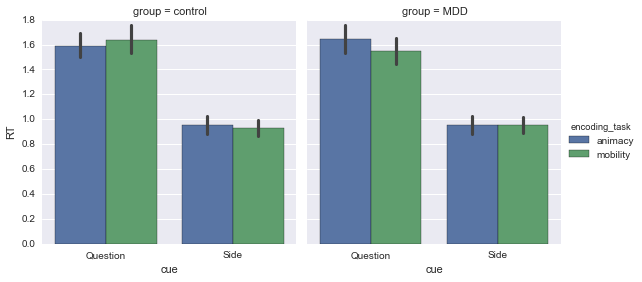

In [201]:
# Strong effect of Cue, no big effects of Group or Task, maybe a Group x Cue x Task . . . 
noe_nog_corr = noe_nog[noe_nog.accuracy == 1]
sns.factorplot(y='RT',x='cue',hue='encoding_task',col='group',units='subject',ci=68,kind='bar',data=noe_nog_corr)

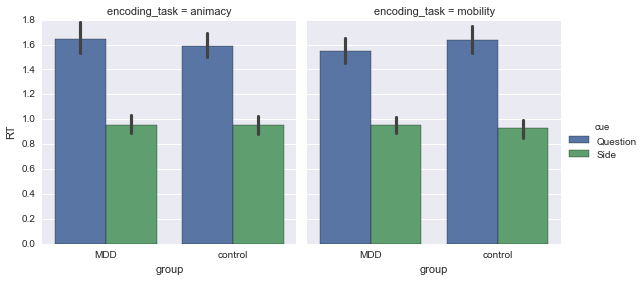

In [202]:
sns.factorplot(y='RT',x='group',hue='cue',col='encoding_task',units='subject',ci=68,kind='bar',data=noe_nog_corr,
              order = ['MDD','control'])
sns.plt.savefig(path2figs + 'Ret_RT_GxCxT_new.pdf')

In [203]:
# First drop the two subs with no RT data, then run the ANOVA . . . and the only sig effect is the huge Cue effect.

noe_nog_corr_clean = noe_nog_corr[~((noe_nog_corr.subject == 'SM045') | (noe_nog_corr.subject == 'SM046'))]
%Rpush noe_nog_corr_clean
# %R str(noe_nog_corr_clean)

%R ret_rt <- ezANOVA(dv=RT, wid=subject, within=.(cue,encoding_task), between=group, data=noe_nog_corr_clean)
%R print(ret_rt)

$ANOVA
                   Effect DFn DFd            F            p p<.05          ges
2                   group   1  44 6.665763e-03 9.353000e-01       1.221835e-04
3                     cue   1  44 1.949858e+02 8.945357e-18     * 3.720393e-01
5           encoding_task   1  44 2.908524e+00 9.516376e-02       1.886507e-03
4               group:cue   1  44 2.097014e-02 8.855216e-01       6.371286e-05
6     group:encoding_task   1  44 1.432397e+00 2.377826e-01       9.299617e-04
7       cue:encoding_task   1  44 5.767113e-01 4.516539e-01       4.074069e-04
8 group:cue:encoding_task   1  44 2.877739e+00 9.687706e-02       2.029626e-03



In [204]:
# Here are the descriptives on the Cue effect (RT in ms)
g = noe_nog_corr_clean.groupby(['subject','group','cue','encoding_task'])['RT'].mean()
df = g.to_frame()
df.reset_index(inplace=True)
print 1000*(df.groupby('cue')['RT'].mean())
print 1000*(df.groupby('cue')['RT'].std())

cue
Question    1619.105743
Side         958.978519
Name: RT, dtype: float64
cue
Question    519.317905
Side        322.706800
Name: RT, dtype: float64


So the **bottom line** with respect to correct RT is that there is only one strong effect: everyone is slower in response to the Question cue vs. the Side cue.

### Confidence 

Confidence is coded as "high" or "low", which isn't super helpful for ANOVAs, so let's re-express that as the percentage of high confidence responses . . . . 

In [205]:
oe['high_confidence'] = oe.confidence.apply(lambda x: 1 if x == 'high' else 0)
noe_nog['high_confidence'] = noe_nog.confidence.apply(lambda x: 1 if x == 'high' else 0)

/Users/ebarrick/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':
/Users/ebarrick/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  from ipykernel import kernelapp as app


#### Odd/Even 

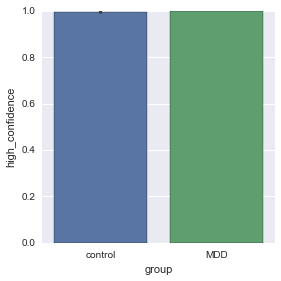

In [206]:
# Shows that eveybody is super confidence on Odd/Even trials.
sns.factorplot(y='high_confidence',x='group',units='subject',ci=68,kind='bar',data=oe)

In [207]:
g = oe.groupby(['subject','group'])['high_confidence'].mean()
df = g.to_frame()
df.reset_index(inplace=True)
df.head()
print 100*(df.groupby('group')['high_confidence'].mean())
print 100*(df.groupby('group')['high_confidence'].std())
misc.ttest_2s(df[df.group == 'control']['high_confidence'],df[df.group == 'MDD']['high_confidence'])

group
MDD        99.869792
control    99.694810
Name: high_confidence, dtype: float64
group
MDD        0.351908
control    0.653259
Name: high_confidence, dtype: float64
t(46) = -1.16, p = 0.254


(-1.155274634980042, 0.2539438198883528)

#### Group x Cue x Task 

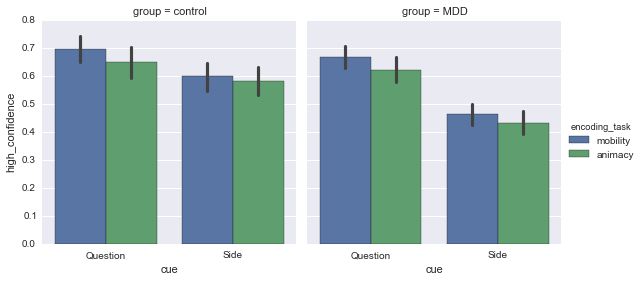

In [208]:
# So I'm seeing main effects of Cue (Q > S), Task (mobility > animacy, and probably a Group x Cue interaction
# because there appears to be HC > MDD under Side but not Cue
sns.factorplot(y='high_confidence',x='cue',hue='encoding_task',col='group',units='subject',ci=68,kind='bar',
               data=noe_nog)

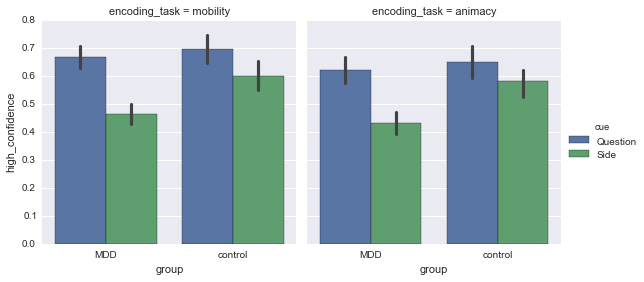

In [209]:
sns.factorplot(y='high_confidence',x='group',hue='cue',col='encoding_task',units='subject',ci=68,kind='bar',
               data=noe_nog,order = ['MDD','control'])
sns.plt.savefig(path2figs + 'Ret_Conf_GxCxT_new.pdf')

In [210]:
# Let's get some descriptives
g = noe_nog.groupby(['subject','group','cue','encoding_task'])['high_confidence'].mean()
df = g.to_frame()
df.reset_index(inplace=True)
# df.head()
print 100*(df.groupby(['group','cue','encoding_task'])['high_confidence'].mean())
print '\n'
print 100*(df.groupby(['group','cue','encoding_task'])['high_confidence'].std())

group    cue       encoding_task
MDD      Question  animacy          61.993910
                   mobility         65.848451
         Side      animacy          42.425926
                   mobility         45.459879
control  Question  animacy          63.620718
                   mobility         68.580769
         Side      animacy          56.596250
                   mobility         58.848322
Name: high_confidence, dtype: float64


group    cue       encoding_task
MDD      Question  animacy          20.082089
                   mobility         19.036603
         Side      animacy          18.558922
                   mobility         17.907900
control  Question  animacy          26.318211
                   mobility         23.254590
         Side      animacy          24.170202
                   mobility         25.825928
Name: high_confidence, dtype: float64


In [211]:
# Yup, main effects of Cue and Task plus a Group x Cue interaction

%Rpush noe_nog
# %R str(noe_nog)

%R ret_conf <- ezANOVA(dv=high_confidence, wid=subject, within=.(cue,encoding_task), between=group, data=noe_nog)
%R print(ret_conf)

$ANOVA
                   Effect DFn DFd            F            p p<.05          ges
2                   group   1  46  2.101584506 1.539307e-01       3.282390e-02
3                     cue   1  46 26.100952398 6.093812e-06     * 9.677930e-02
5           encoding_task   1  46  6.722888266 1.271939e-02     * 6.579992e-03
4               group:cue   1  46  4.367635639 4.218467e-02     * 1.761411e-02
6     group:encoding_task   1  46  0.003541379 9.528041e-01       3.489052e-06
7       cue:encoding_task   1  46  0.829521565 3.671590e-01       4.146030e-04
8 group:cue:encoding_task   1  46  0.237331113 6.284539e-01       1.186555e-04



In [212]:
# Okay, so let's just run b/w group t-tests on % high confidence responses at each level of cue
g = noe_nog.groupby(['subject','group','cue'])['high_confidence'].mean()
df = g.to_frame()
df.reset_index(inplace=True)
df.head()

# Question: no difference
misc.ttest_2s(df[(df.group == 0) & (df.cue == 'Question')]['high_confidence'],
              df[(df.group == 1) & (df.cue == 'Question')]['high_confidence'], paired=False)

# Side: group difference, HC > MDD
misc.ttest_2s(df[(df.group == 0) & (df.cue == 'Side')]['high_confidence'],
              df[(df.group == 1) & (df.cue == 'Side')]['high_confidence'], paired=False)

t(-2) = nan, p = nan
t(-2) = nan, p = nan


(nan, nan)

So the **bottom line** with respect to confidence is that everybody is more confident in response to the Question vs. the Side cue and in response to words from the mobility vs. the animacy task, and the depressed group was less confident than the control group under the Side cue.

### Confidence and Accuracy

In [303]:
g = noe.groupby(['subject','group','cue','encoding_task','confidence'])['accuracy'].mean()
c_a = g.to_frame()
c_a.reset_index(inplace=True)
c_a.head()

,subject,group,cue,encoding_task,confidence,accuracy
0,SM011,control,Question,animacy,high,0.702128
1,SM011,control,Question,mobility,high,0.318182
2,SM011,control,Question,mobility,low,0.000000
3,SM011,control,Question,mobility,nan,NaN
4,SM011,control,Side,animacy,high,0.448276


## ERPs 

Let's try the same Group x Cue x Task approach with the ANOVAs, relying on the MUT. The challenge with that is that's it not possible to simply run the ANOVA in one-step, so we will need to do it in a more piecemeal fashion. Here's how: (1) in controls, compute a "mobility - animacy" difference wave under the Question cue (so Q:M-A), repeat that under the Side cue (so S:M-A), and the compute a difference of differences (so Q:M-A minus S:M-A); (2) repeat all that in the MDD group; and (3) do Controls vs. MDD for Q:M-A minus S:M-A. That is the equivalent of the full 2 x 2 x 2 ANOVA. If we find significant group differences, we can look at the waveforms in electrodes that show the difference.

In [213]:
%cd {path2erps}

/Users/ebarrick/Work/Expts/SOURCE/Analysis/ERPs


In [214]:
#clean up csv files, adding in columns for cue, task, and laterality

def elec2laterality(electrode):
       
    left = [48,49,43,56,44,38,57,63,128,39,45,50,32,33,40,46,58,64,68,34,51,35,41,47,25,26,27,59,65,28,52,36,69,
           42,23,29,73,24,53,22,60,66,21,20,30,37,70,127,18,19,13,31,54,61,67,74,71,12,7]
    right = [5,106,126,10,4,112,80,79,78,77,76,82,14,118,105,87,83,9,86,85,84,88,3,124,111,104,93,89,117,92,8,2,
             123,98,91,90,110,103,116,97,1,122,109,102,96,95,94,115,108,101,125,121,114,100,99,120,113,107,119]
    midline = [17,15,16,11,6,55,62,72,75,81]
    
    if electrode in left:
        laterality = 'left'
    elif electrode in right:
        laterality = 'right'
    elif electrode in midline:
        laterality = 'midline'

    return laterality

def condition2task(condition):
    
    animacy = [97,111]
    mobility = [104,118]
    
    if condition in animacy:
        task = 'animacy'
    elif condition in mobility:
        task = 'mobility'

    return task

def condition2cue(condition):
    
    side = [97,104]
    question = [111,118]
    
    if condition in side:
        cue = 'Side'
    elif condition in question:
        cue = 'Question'

    return cue
    
def make_clean_df(csv):
    '''Read in a mean amps CSV and return a cleaned up df.'''
    df = pd.read_csv(csv,sep="\t",skipinitialspace=True)
    new_cols = ['time','uV','electrode','electrode_label','condition','subject']
    df.columns = new_cols
    df.electrode_label.replace({'E60':'P1','E52':'P3','E51':'P5',
                                'E58':'P7','E85':'P2','E92':'P4','E97':'P6',
                                'E96':'P8','E26':'AF7','E19':'F1',
                                'E24':'F3','E27':'F5','E33':'F7',
                               'E2':'AF8','E4':'F2','E124':'F4',
                                'E123':'F6','E122':'F8',
                               'E67':'PO3','E70':'O1','E62':'Pz',
                                'E72':'POz','E75':'Oz','E77':'PO4','E83':'O2'},
                               inplace=True)    
    df.subject = df.subject.map(lambda x: x.strip('_ERPs'))
    df['laterality'] = df.electrode.map(lambda x: elec2laterality(x))
    df['task'] = df.condition.map(lambda x: condition2task(x))
    df['cue'] = df.condition.map(lambda x: condition2cue(x))
    df = df[['subject','time','condition','cue','task','laterality',
             'electrode','electrode_label','uV']]
    df.condition.replace({97:'animacy side hit', 104:'mobility side hit', 
                          111:'animacy question hit',
                          118:'mobility question hit'},inplace=True)
    
    return df

### The following analyses are based on the traditional 4 left (P3, P5, P7, P1) and 4 right (P4, P6, P8, P2) electrodes

In [215]:
hc_par = make_clean_df(path2erps + 'MeanAmps/HC/HC_EncTask_RetCue_Parietal_400_800.txt')
mdd_par = make_clean_df(path2erps + 'MeanAmps/MDD/MDD_EncTask_RetCue_Parietal_400_800.txt')
hc_par['group'] = 'control'
mdd_par['group'] = 'MDD'
all_par = pd.concat([hc_par,mdd_par])
all_par.head()

,subject,time,condition,cue,task,laterality,electrode,electrode_label,uV,group
0,SM011,[400.0 800.0],animacy side hit,Side,animacy,left,51,P5,-0.992,control
1,SM011,[400.0 800.0],animacy side hit,Side,animacy,left,52,P3,1.481,control
2,SM011,[400.0 800.0],animacy side hit,Side,animacy,left,58,P7,-0.048,control
3,SM011,[400.0 800.0],animacy side hit,Side,animacy,left,60,P1,-1.063,control
4,SM011,[400.0 800.0],animacy side hit,Side,animacy,right,85,P2,-0.861,control


In [216]:
all_par.electrode_label.unique()

array(['P5', 'P3', 'P7', 'P1', 'P2', 'P4', 'P8', 'P6'], dtype=object)

In [217]:
all_par.groupby('group')['subject'].nunique()

group
MDD        24
control    24
Name: subject, dtype: int64

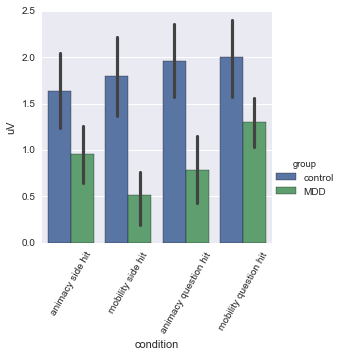

In [218]:
f = sns.factorplot(y = 'uV', x = 'condition',hue='group',kind='bar',units='subject',ci=68,
                   data=all_par)
f.set_xticklabels(rotation=60)

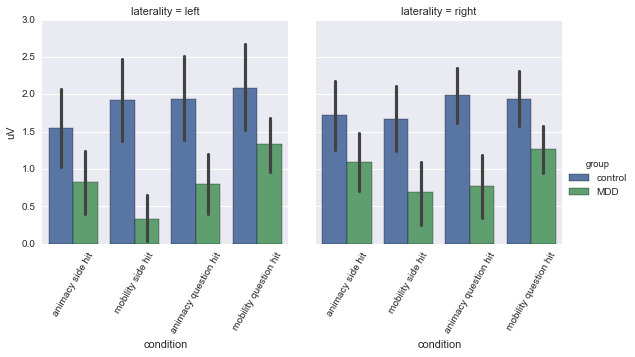

In [219]:
f = sns.factorplot(y = 'uV', x = 'condition',hue='group',col='laterality',kind='bar',units='subject',ci=68,
                   data=all_par)
f.set_xticklabels(rotation=60)

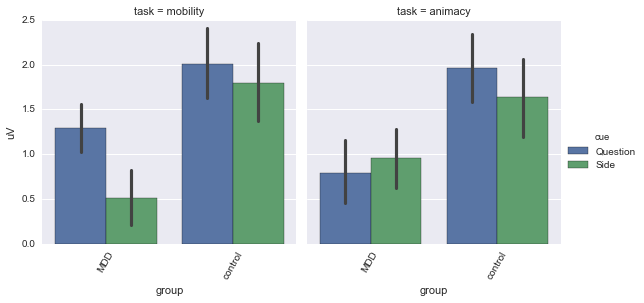

In [220]:
f = sns.factorplot(y = 'uV', x = 'group',hue='cue',col='task',kind='bar',units='subject',ci=68,
                   data=all_par, order =['MDD','control'],col_order=['mobility','animacy'],hue_order=['Question','Side'])
f.set_xticklabels(rotation=60)
sns.plt.savefig(path2figs + 'Par_uV_GxCxT.pdf')

In [221]:
#significant effect of group and cue, but not for GroupxCuexTask (though trending in the direction)

%Rpush all_par

%R erp_par <- ezANOVA(dv=uV, wid=subject, within=.(cue,task,laterality), between=group, data=all_par)
%R print(erp_par)

$ANOVA
                      Effect DFn DFd           F          p p<.05          ges
2                      group   1  46  4.48335496 0.03966354     * 5.293110e-02
3                        cue   1  46 10.34378385 0.00237944     * 5.040041e-03
5                       task   1  46  0.37900348 0.54117126       2.651048e-04
7                 laterality   1  46  0.02152881 0.88398868       1.214792e-04
4                  group:cue   1  46  0.03700366 0.84830432       1.812116e-05
6                 group:task   1  46  0.10860080 0.74323871       7.597829e-05
8           group:laterality   1  46  0.08108244 0.77711390       4.573648e-04
9                   cue:task   1  46  1.95804988 0.16842945       2.697534e-03
11            cue:laterality   1  46  1.41796608 0.23984712       5.016650e-04
13           task:laterality   1  46  0.79427935 0.37744735       2.920873e-04
10            group:cue:task   1  46  3.17517741 0.08136696       4.367004e-03
12      group:cue:laterality   1  46  1.40922

In [222]:
g = all_par.groupby(['subject','group','condition'])['uV'].mean()

df2=pd.DataFrame(g)
df2.reset_index(inplace=True)

df2.head()

,subject,group,condition,uV
0,SM011,control,animacy question hit,1.505500
1,SM011,control,animacy side hit,-0.317625
2,SM011,control,mobility question hit,1.684625
3,SM011,control,mobility side hit,0.959875
4,SM013,control,animacy question hit,1.938375


In [223]:
df3 = df2.pivot_table(index=['subject','group'], columns='condition', values='uV')
df3.reset_index(drop=False,inplace=True)
df3.columns = ['subject','group','animacy question','animacy side','mobility question','mobility side']
df3.head()

,subject,group,animacy question,animacy side,mobility question,mobility side
0,SM011,control,1.505500,-0.317625,1.684625,0.959875
1,SM013,control,1.938375,1.436750,3.152250,1.768750
2,SM014,control,-0.235000,-1.564125,-1.428875,-0.442625
3,SM015,MDD,1.306375,0.613625,1.887500,1.378250
4,SM017,control,3.690625,4.321750,4.313875,4.182875


In [224]:
df3['animacy q-s'] = df3['animacy question']-df3['animacy side']
df3['mobility q-s'] = df3['mobility question']-df3['mobility side']

In [225]:
df3.head()

,subject,group,animacy question,animacy side,mobility question,mobility side,animacy q-s,mobility q-s
0,SM011,control,1.505500,-0.317625,1.684625,0.959875,1.823125,0.72475
1,SM013,control,1.938375,1.436750,3.152250,1.768750,0.501625,1.38350
2,SM014,control,-0.235000,-1.564125,-1.428875,-0.442625,1.329125,-0.98625
3,SM015,MDD,1.306375,0.613625,1.887500,1.378250,0.692750,0.50925
4,SM017,control,3.690625,4.321750,4.313875,4.182875,-0.631125,0.13100


In [226]:
animacy_diff = df3[['subject', 'group', 'animacy q-s']].copy()
animacy_diff['task'] = 'animacy'
animacy_diff.columns = ['subject','group','value','task']

mobility_diff=df3[['subject','group','mobility q-s']].copy()
mobility_diff['task'] = 'mobility'
mobility_diff.columns = ['subject','group','value','task']

In [227]:
# Question-Side by task
g = pd.concat([mobility_diff,animacy_diff])
df4 = pd.DataFrame(g)
df4.head()

,subject,group,value,task
0,SM011,control,0.72475,mobility
1,SM013,control,1.38350,mobility
2,SM014,control,-0.98625,mobility
3,SM015,MDD,0.50925,mobility
4,SM017,control,0.13100,mobility


In [228]:
%Rpush df4

%R uv_par <- ezANOVA(dv=value, wid=subject, within=task, between=group, data=df4)
%R print (uv_par)

$ANOVA
      Effect DFn DFd          F          p p<.05          ges
2      group   1  46 0.03700366 0.84830432       0.0002104965
3       task   1  46 1.95804988 0.16842945       0.0304680535
4 group:task   1  46 3.17517741 0.08136696       0.0484887256



In [229]:
misc.ttest_2s(df4[(df4.group == 'control') & (df4.task == 'mobility')]['value'],
             df4[(df4.group == 'MDD') & (df4.task == 'mobility')]['value'], paired=False)

misc.ttest_2s(df4[(df4.group == 'control') & (df4.task == 'animacy')]['value'],
             df4[(df4.group == 'MDD') & (df4.task == 'animacy')]['value'],paired = False)

misc.ttest_2s(df4[(df4.group == 'control') & (df4.task == 'mobility')]['value'],
             df4[(df4.group == 'control') & (df4.task == 'animacy')]['value'], paired = True)

misc.ttest_2s(df4[(df4.group == 'MDD') & (df4.task == 'mobility')]['value'],
             df4[(df4.group == 'MDD') & (df4.task == 'animacy')]['value'], paired = True)

t(46) = -1.70, p = 0.096
t(46) = 1.38, p = 0.175
t(23) = -0.32, p = 0.749
t(23) = 1.97, p = 0.061


(1.9711360791482013, 0.060857240700011667)

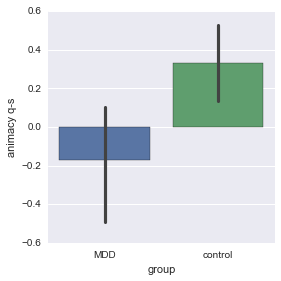

In [230]:
sns.factorplot(y='animacy q-s',x='group',units='subject',ci=68,kind='bar',data=df3, order =['MDD','control'])
sns.plt.savefig(path2figs + 'Par_uV_animacy_diff.pdf')

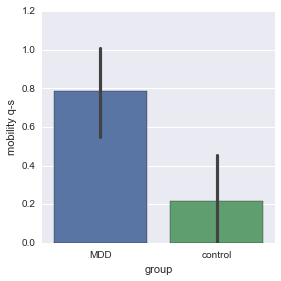

In [231]:
sns.factorplot(y='mobility q-s',x='group',units='subject',ci=68,kind='bar',data=df3, order = ['MDD','control'])
sns.plt.savefig(path2figs + 'Par_uV_mobility_diff.pdf')

In [232]:
g = all_par.groupby(['subject','group','cue','task'])['uV'].mean()
df5=pd.DataFrame(g)
df5.reset_index(inplace=True)

In [233]:
#New table for mobility accuracy
MI_acc = table_MI[['subject', 'group', 'Question','Side','Q-S']].copy()

MI_acc.columns = ['subject','group','mobility question acc','mobility side acc','mobility Q-S acc']

In [234]:
#New table for animacy accuracy
LNL_acc = table_LNL[['subject', 'group', 'Question','Side','Q-S']].copy()

LNL_acc.columns = ['subject','group','animacy question acc','animacy side acc','animacy Q-S acc']

In [235]:
#merging mobility and animacy tables to make full accruacy table with relevant information

acc_table = pd.merge(MI_acc,LNL_acc,on=['subject','group'])

In [236]:
# Table with accuracy and uV for task+cue and task question-side
uv_acc= pd.merge(df3,acc_table,on=['subject','group'])
uv_acc.head()

,subject,group,animacy question,animacy side,mobility question,mobility side,animacy q-s,mobility q-s,mobility question acc,mobility side acc,mobility Q-S acc,animacy question acc,animacy side acc,animacy Q-S acc
0,SM011,control,1.505500,-0.317625,1.684625,0.959875,1.823125,0.72475,0.304348,0.434783,-0.130435,0.702128,0.437500,0.264628
1,SM013,control,1.938375,1.436750,3.152250,1.768750,0.501625,1.38350,0.717391,0.700000,0.017391,0.476190,0.790698,-0.314507
2,SM014,control,-0.235000,-1.564125,-1.428875,-0.442625,1.329125,-0.98625,0.744186,0.869565,-0.125379,0.723404,0.941176,-0.217772
3,SM015,MDD,1.306375,0.613625,1.887500,1.378250,0.692750,0.50925,0.765957,0.541667,0.224291,0.413043,0.541667,-0.128623
4,SM017,control,3.690625,4.321750,4.313875,4.182875,-0.631125,0.13100,0.854167,0.860465,-0.006298,0.652174,0.780488,-0.128314


/Users/ebarrick/anaconda/lib/python2.7/site-packages/matplotlib/collections.py:590: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == str('face'):


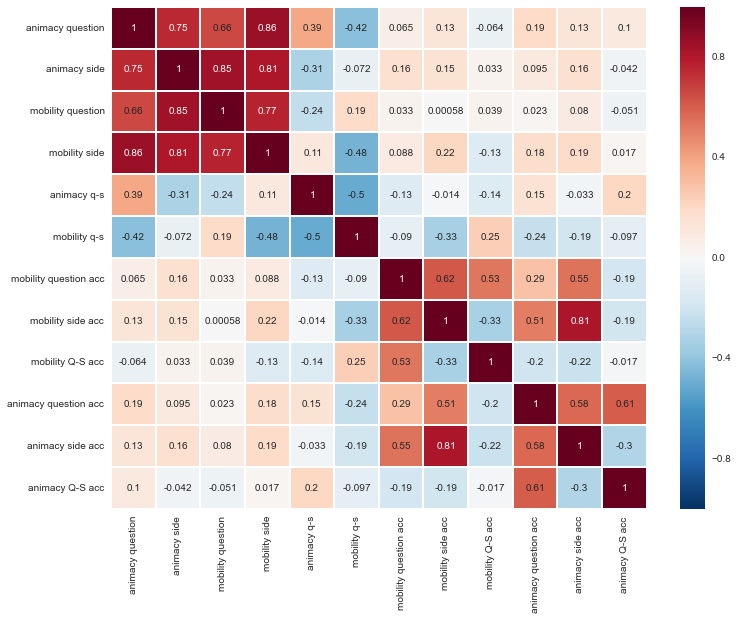

In [237]:
corr = uv_acc.corr()


f, ax = plt.subplots(figsize=(12, 9))
sns.heatmap(corr, annot=True, linewidths=.5)
plt.show()


In [238]:
df5_LNL = df5[df5.task == 'animacy']
%Rpush df5_LNL

%R df5_LNL <- ezANOVA(dv=uV, wid=subject, within=cue, between=group, data=df5_LNL)
%R print(df5_LNL)

$ANOVA
     Effect DFn DFd         F          p p<.05          ges
2     group   1  46 3.7527604 0.05887524       0.0664434521
3       cue   1  46 0.1817824 0.67183458       0.0005039715
4 group:cue   1  46 1.9007287 0.17466481       0.0052445657



In [239]:
df5_MI = df5[df5.task == 'mobility']
%Rpush df5_MI

%R df5_MI <- ezANOVA(dv=uV, wid=subject, within=cue, between=group, data=df5_MI)
%R print(df5_MI)

$ANOVA
     Effect DFn DFd        F           p p<.05         ges
2     group   1  46 4.800646 0.033552522     * 0.084032749
3       cue   1  46 8.812984 0.004736857     * 0.022642716
4 group:cue   1  46 2.885562 0.096131828       0.007528365



### The following analyses are conducted using the electrodes found to be siginificant under Question-Side/Depressed-Controls for the MUT analysis.

A couple of issues . . .  looks like the same electrodes were used for the 400-800 and 800-1400 ms analysis, and they should be different based on our Table 2. Also, since we did not find any signficant group differences in Q-S/mobility from 1400-2000 ms in the MUT, we should not have any analyses for that time window. 

In [242]:
# for 400-800 ms
hc_par3 = make_clean_df(path2erps + 'MeanAmps/HC/HC_cueDiff_taskDiff_Par_400_800.txt')
mdd_par3 = make_clean_df(path2erps + 'MeanAmps/MDD/MDD_cueDiff_taskDiff_Par_400_800.txt')
hc_par3['group'] = 'control'
mdd_par3['group'] = 'MDD'
all_par3 = pd.concat([hc_par3,mdd_par3],axis=0)
all_par3.head()

,subject,time,condition,cue,task,laterality,electrode,electrode_label,uV,group
0,SM011,[400.0 800.0],animacy side hit,Side,animacy,left,34,E34,-0.081,control
1,SM011,[400.0 800.0],animacy side hit,Side,animacy,left,35,E35,2.240,control
2,SM011,[400.0 800.0],animacy side hit,Side,animacy,left,40,E40,2.227,control
3,SM011,[400.0 800.0],animacy side hit,Side,animacy,left,41,E41,2.679,control
4,SM011,[400.0 800.0],animacy side hit,Side,animacy,left,42,E42,1.070,control


In [243]:
# Group x Cue X Task within significant electrodes in MUT analysis
%Rpush all_par3

%R uv_par3 <- ezANOVA(dv=uV, wid=subject, within=.(task, cue), between=group, data=all_par3)
%R print(uv_par3)

$ANOVA
          Effect DFn DFd          F           p p<.05          ges
2          group   1  46 0.94028767 0.337275081       0.0149390168
3           task   1  46 1.97737574 0.166386680       0.0031922415
5            cue   1  46 0.97872320 0.327689725       0.0014590983
4     group:task   1  46 0.08057854 0.777788725       0.0001304842
6      group:cue   1  46 3.35132826 0.073633382       0.0049786109
7       task:cue   1  46 1.88499988 0.176423282       0.0046865230
8 group:task:cue   1  46 8.23300448 0.006193663     * 0.0201510200



In [244]:
all_par3_MI = all_par3[all_par3.task == 'mobility']
%Rpush all_par3_MI
%R uv_par_MI <- ezANOVA(dv=uV, wid=subject, within=cue, between=group, data=all_par3_MI)
%R print(uv_par_MI)

$ANOVA
     Effect DFn DFd          F            p p<.05         ges
2     group   1  46  1.1112776 2.973102e-01       0.020536590
3       cue   1  46  0.3724535 5.446734e-01       0.001068354
4 group:cue   1  46 18.4895152 8.799006e-05     * 0.050415769



In [245]:
# for 800-1400 ms
hc_par4 = make_clean_df(path2erps + 'MeanAmps/HC/HC_cueDiff_taskDiff_Par_800_1400.txt')
mdd_par4 = make_clean_df(path2erps + 'MeanAmps/MDD/MDD_cueDiff_taskDiff_Par_800_1400.txt')
hc_par4['group'] = 'control'
mdd_par4['group'] = 'MDD'
all_par4 = pd.concat([hc_par4,mdd_par4],axis=0)
all_par4.head()

,subject,time,condition,cue,task,laterality,electrode,electrode_label,uV,group
0,SM011,[800.0 1400.0],animacy side hit,Side,animacy,left,40,E40,4.433,control
1,SM011,[800.0 1400.0],animacy side hit,Side,animacy,left,41,E41,4.129,control
2,SM011,[800.0 1400.0],animacy side hit,Side,animacy,left,42,E42,0.124,control
3,SM011,[800.0 1400.0],animacy side hit,Side,animacy,left,46,E46,-1.663,control
4,SM011,[800.0 1400.0],animacy side hit,Side,animacy,left,47,E47,0.768,control


In [246]:
%Rpush all_par4

%R uv_par4 <- ezANOVA(dv=uV, wid=subject, within=.(task, cue), between=group, data=all_par4)
%R print(uv_par4)

$ANOVA
          Effect DFn DFd          F          p p<.05          ges
2          group   1  46 3.79681628 0.05746528       5.385817e-02
3           task   1  46 0.64197789 0.42711490       8.165703e-04
5            cue   1  46 0.02565892 0.87343748       6.084949e-05
4     group:task   1  46 0.34636788 0.55905531       4.407319e-04
6      group:cue   1  46 4.07048101 0.04949491     * 9.561330e-03
7       task:cue   1  46 3.29361322 0.07607339       1.011331e-02
8 group:task:cue   1  46 4.97834148 0.03058194     * 1.520773e-02



In [247]:
all_par4_MI = all_par4[all_par4.task == 'mobility']
%Rpush all_par4_MI
%R uv_par4_MI <- ezANOVA(dv=uV, wid=subject, within=cue, between=group, data=all_par4_MI)
%R print(uv_par4_MI)

$ANOVA
     Effect DFn DFd         F            p p<.05        ges
2     group   1  46  3.019594 0.0889555476       0.05229132
3       cue   1  46  3.985636 0.0518282025       0.01362708
4 group:cue   1  46 16.647845 0.0001771435     * 0.05455783



###Follow-up tests on the group difference in Q-S uV in each time window . . .  

#### 400-800 ms 

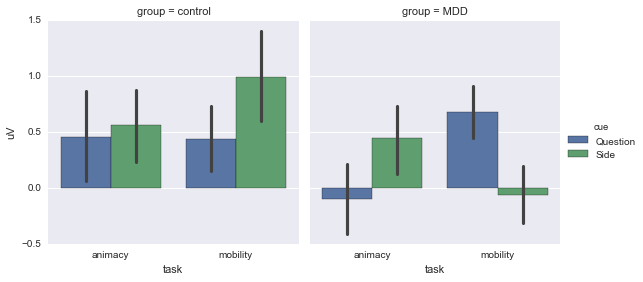

In [248]:
sns.factorplot(y='uV', x='task', hue='cue',col='group',units='subject',ci=68, kind='bar', data=all_par3,
              hue_order=['Question','Side'])

In [249]:
all_par3_MI.head()
g = all_par3_MI.groupby(['subject','group','cue'])['uV'].mean()
df = g.to_frame()
df.reset_index(inplace=True)
par_table_MI = df.pivot_table(index=['subject','group'],columns='cue',values='uV')
par_table_MI.reset_index(inplace=True)
new_cols = ['subject','group','question','side']
par_table_MI.columns = new_cols
par_table_MI['Q-S'] = par_table_MI['question']-par_table_MI['side']
par_table_MI['condition'] = 'mobility'
par_table_MI.head()

,subject,group,question,side,Q-S,condition
0,SM011,control,0.9477,0.9382,0.0095,mobility
1,SM013,control,0.7688,1.0773,-0.3085,mobility
2,SM014,control,0.1516,0.0330,0.1186,mobility
3,SM015,MDD,1.0759,1.3718,-0.2959,mobility
4,SM017,control,1.8646,3.3084,-1.4438,mobility


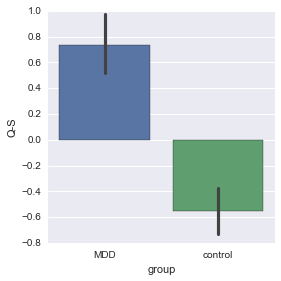

In [250]:
#Question-side for mobility uV 400-800 ms
sns.factorplot(y='Q-S',x='group',units='subject',ci=68,kind='bar',data=par_table_MI,
              order = ['MDD','control'])

In [251]:
misc.ttest_2s(par_table_MI[par_table_MI.group == 'control']['Q-S'],
             par_table_MI[par_table_MI.group == 'MDD']['Q-S'])

t(46) = -4.30, p = 0.000


(-4.2999436302497998, 8.7990055988736857e-05)

#### 800-1400 ms 

In [252]:
all_par4_MI.head()

,subject,time,condition,cue,task,laterality,electrode,electrode_label,uV,group
9,SM011,[800.0 1400.0],mobility side hit,Side,mobility,left,40,E40,0.303,control
10,SM011,[800.0 1400.0],mobility side hit,Side,mobility,left,41,E41,-0.100,control
11,SM011,[800.0 1400.0],mobility side hit,Side,mobility,left,42,E42,1.710,control
12,SM011,[800.0 1400.0],mobility side hit,Side,mobility,left,46,E46,6.849,control
13,SM011,[800.0 1400.0],mobility side hit,Side,mobility,left,47,E47,0.103,control


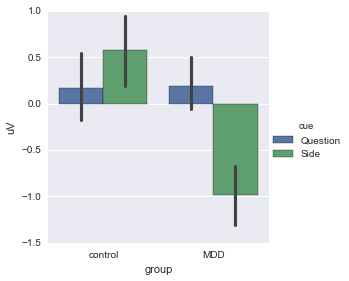

In [253]:
sns.factorplot(y='uV', x='group',hue='cue',units='subject',ci=68, kind='bar', data=all_par4_MI,
              hue_order=['Question','Side'])

In [254]:
g = all_par4_MI.groupby(['subject','group','cue'])['uV'].mean()
df = g.to_frame()
df.reset_index(inplace=True)
par_MI_800_1400 = df.pivot_table(index=['subject','group'],columns='cue',values='uV')
par_MI_800_1400.reset_index(inplace=True)
par_MI_800_1400['Q-S'] = par_MI_800_1400.Question - par_MI_800_1400.Side
par_MI_800_1400.head()

cue,subject,group,Question,Side,Q-S
0,SM011,control,-0.049444,1.324889,-1.374333
1,SM013,control,0.833333,0.194444,0.638889
2,SM014,control,-1.124111,-0.557667,-0.566444
3,SM015,MDD,-0.372000,0.328778,-0.700778
4,SM017,control,2.431222,3.437000,-1.005778


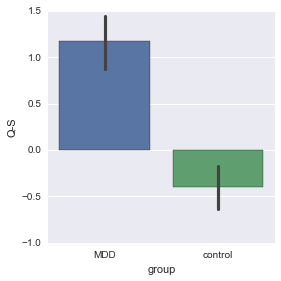

In [255]:
sns.factorplot(y='Q-S',x='group',units='subject',ci=68,kind='bar',data=par_MI_800_1400,
              order = ['MDD','control'])

In [256]:
misc.ttest_2s(par_MI_800_1400[par_MI_800_1400.group == 'control']['Q-S'],
              par_MI_800_1400[par_MI_800_1400.group == 'MDD']['Q-S'],
              paired=False)

t(46) = -4.08, p = 0.000


(-4.0801770853882777, 0.00017714351111066122)

### ANOVAs: uV from the MUT Q-S/animacy electrodes

#### 400-800 ms

In [257]:
hc_par6 = make_clean_df(path2erps + 'MeanAmps/HC/HC_cueDiff_taskDiff_Par_400_800_2.txt')
mdd_par6 = make_clean_df(path2erps + 'MeanAmps/MDD/MDD_cueDiff_taskDiff_Par_400_800_2.txt')
hc_par6['group'] = 'control'
mdd_par6['group'] = 'MDD'
all_par6 = pd.concat([hc_par6,mdd_par6],axis=0)
all_par6.head()

,subject,time,condition,cue,task,laterality,electrode,electrode_label,uV,group
0,SM011,[400.0 800.0],animacy side hit,Side,animacy,midline,6,E6,-0.345,control
1,SM011,[400.0 800.0],animacy side hit,Side,animacy,left,7,E7,0.998,control
2,SM011,[400.0 800.0],animacy side hit,Side,animacy,midline,11,E11,-0.202,control
3,SM011,[400.0 800.0],animacy side hit,Side,animacy,left,12,E12,-2.039,control
4,SM011,[400.0 800.0],animacy side hit,Side,animacy,left,13,E13,-0.400,control


In [258]:
all_par6.electrode.unique()

array([ 6,  7, 11, 12, 13, 16, 19, 21, 24, 25, 28, 29, 30, 31, 32, 34, 35,
       36])

In [259]:
%Rpush all_par6

%R uv_par6 <- ezANOVA(dv=uV, wid=subject, within=.(task,cue), between=group, data=all_par6)
%R print(uv_par6)

$ANOVA
          Effect DFn DFd           F            p p<.05          ges
2          group   1  46  1.15559996 0.2879863221       1.932221e-02
3           task   1  46  2.07281796 0.1567154012       1.972247e-03
5            cue   1  46 15.60424006 0.0002661978     * 2.264693e-02
4     group:task   1  46  0.10444415 0.7480248845       9.956307e-05
6      group:cue   1  46  0.03925868 0.8438101217       5.829425e-05
7       task:cue   1  46  2.58701998 0.1145856737       5.789323e-03
8 group:task:cue   1  46  2.23450528 0.1417888835       5.004401e-03



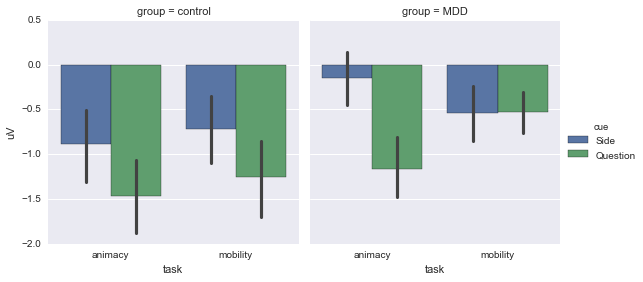

In [260]:
sns.factorplot(y='uV',x='task',hue='cue',col='group',units='subject',ci=68,kind='bar',
               data=all_par6)

#### 800-1400

In [261]:
hc_par7 = make_clean_df(path2erps + 'MeanAmps/HC/HC_cueDiff_taskDiff_Par_800_1400_2.txt')
mdd_par7 = make_clean_df(path2erps + 'MeanAmps/MDD/MDD_cueDiff_taskDiff_Par_800_1400_2.txt')
hc_par7['group'] = 'control'
mdd_par7['group'] = 'MDD'
all_par7 = pd.concat([hc_par7,mdd_par7],axis=0)
all_par7.head()

,subject,time,condition,cue,task,laterality,electrode,electrode_label,uV,group
0,SM011,[800.0 1400.0],animacy side hit,Side,animacy,right,2,AF8,3.820,control
1,SM011,[800.0 1400.0],animacy side hit,Side,animacy,right,5,E5,-2.095,control
2,SM011,[800.0 1400.0],animacy side hit,Side,animacy,midline,6,E6,0.084,control
3,SM011,[800.0 1400.0],animacy side hit,Side,animacy,left,7,E7,1.161,control
4,SM011,[800.0 1400.0],animacy side hit,Side,animacy,midline,11,E11,0.722,control


In [262]:
all_par7.electrode.unique()

array([  2,   5,   6,   7,  11,  12,  13,  16,  19,  20,  24,  27,  28,
        29,  30,  31,  35,  36,  37,  42,  79,  80,  86,  87,  92,  93,
        98, 102, 103, 104, 105, 106, 109, 111, 112, 117, 118, 123, 124])

In [263]:
%Rpush all_par7

%R uv_par7 <- ezANOVA(dv=uV, wid=subject, within=.(task, cue), between=group, data=all_par7)
%R print(uv_par7)

$ANOVA
          Effect DFn DFd           F            p p<.05          ges
2          group   1  46  0.05406794 8.171616e-01       0.0007519829
3           task   1  46  0.36217757 5.502542e-01       0.0004678693
5            cue   1  46 27.86368098 3.431976e-06     * 0.0825690940
4     group:task   1  46  0.19351283 6.620689e-01       0.0002500388
6      group:cue   1  46  0.08841650 7.675387e-01       0.0002855058
7       task:cue   1  46  3.70479481 6.045373e-02       0.0120712988
8 group:task:cue   1  46  2.46405598 1.233316e-01       0.0080611998



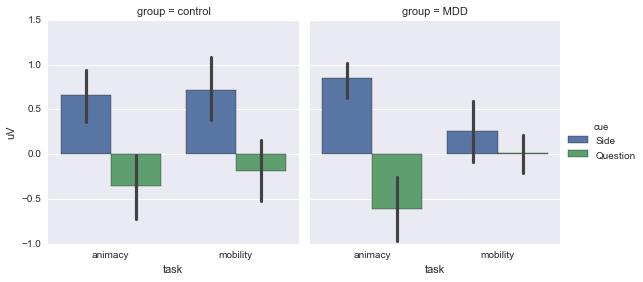

In [264]:
sns.factorplot(y='uV',x='task',hue='cue',col='group',units='subject',ci=68,kind='bar',
               data=all_par7)

#### 1400-2000

In [265]:
hc_par8 = make_clean_df(path2erps + 'MeanAmps/HC/HC_cueDiff_taskDiff_Par_1400_2000_2.txt')
mdd_par8 = make_clean_df(path2erps + 'MeanAmps/MDD/MDD_cueDiff_taskDiff_Par_1400_2000_2.txt')
hc_par8['group'] = 'control'
mdd_par8['group'] = 'MDD'
all_par8 = pd.concat([hc_par8,mdd_par8],axis=0)
all_par8.head()

,subject,time,condition,cue,task,laterality,electrode,electrode_label,uV,group
0,SM011,[1400.0 1999.0],animacy side hit,Side,animacy,midline,6,E6,-2.143,control
1,SM011,[1400.0 1999.0],animacy side hit,Side,animacy,left,7,E7,0.114,control
2,SM011,[1400.0 1999.0],animacy side hit,Side,animacy,left,12,E12,-7.094,control
3,SM011,[1400.0 1999.0],animacy side hit,Side,animacy,left,13,E13,-0.446,control
4,SM011,[1400.0 1999.0],animacy side hit,Side,animacy,left,19,F1,-1.212,control


In [266]:
all_par8.electrode.unique()

array([ 6,  7, 12, 13, 19, 24, 27, 28, 29, 30, 31, 35, 36, 37, 79, 80, 86,
       87, 92, 93, 98])

In [267]:
%Rpush all_par8

%R uv_par8 <- ezANOVA(dv=uV, wid=subject, within=.(task, cue), between=group, data=all_par8)
%R print(uv_par8)

$ANOVA
          Effect DFn DFd            F            p p<.05          ges
2          group   1  46  0.198438932 0.6580733383       2.690584e-03
3           task   1  46  0.198177938 0.6582835252       3.766360e-04
5            cue   1  46 20.637055532 0.0000400311     * 7.131706e-02
4     group:task   1  46  0.001143264 0.9731732151       2.173580e-06
6      group:cue   1  46  0.483350788 0.4904057708       1.795396e-03
7       task:cue   1  46  4.626216322 0.0367744550     * 1.153018e-02
8 group:task:cue   1  46  0.075390981 0.7848728125       1.900569e-04



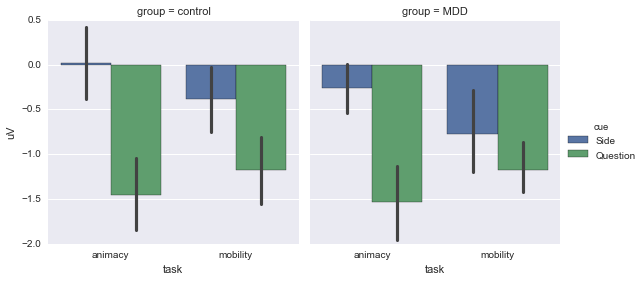

In [268]:
sns.factorplot(y='uV',x='task',hue='cue',col='group',units='subject',ci=68,kind='bar',
               data=all_par8)

### Correlations b/w behavior and uV from the MUT Q-S/mobility electrodes

In [269]:
g = all_par3.groupby(['subject','group','condition'])['uV'].mean()

df6=pd.DataFrame(g)
df6.reset_index(inplace=True)
df6.head()

,subject,group,condition,uV
0,SM011,control,animacy question hit,0.9291
1,SM011,control,animacy side hit,1.1225
2,SM011,control,mobility question hit,0.9477
3,SM011,control,mobility side hit,0.9382
4,SM013,control,animacy question hit,0.4599


In [270]:
df7 = df6.pivot_table(index=['subject','group'], columns='condition', values='uV')
df7.reset_index(drop=False,inplace=True)
df7.columns = ['subject','group','animacy question','animacy side','mobility question','mobility side']


df7['animacy q-s'] = df7['animacy question']-df7['animacy side']
df7['mobility q-s'] = df7['mobility question']-df7['mobility side']
df7.head()

,subject,group,animacy question,animacy side,mobility question,mobility side,animacy q-s,mobility q-s
0,SM011,control,0.9291,1.1225,0.9477,0.9382,-0.1934,0.0095
1,SM013,control,0.4599,-0.1960,0.7688,1.0773,0.6559,-0.3085
2,SM014,control,0.7871,0.1999,0.1516,0.0330,0.5872,0.1186
3,SM015,MDD,0.8339,1.4947,1.0759,1.3718,-0.6608,-0.2959
4,SM017,control,0.5303,1.1543,1.8646,3.3084,-0.6240,-1.4438


In [271]:
df7.subject.nunique()

48

In [272]:
acc_table_new = acc_table.copy()
acc_table_new.head()

,subject,group,mobility question acc,mobility side acc,mobility Q-S acc,animacy question acc,animacy side acc,animacy Q-S acc
0,SM011,control,0.304348,0.434783,-0.130435,0.702128,0.437500,0.264628
1,SM013,control,0.717391,0.700000,0.017391,0.476190,0.790698,-0.314507
2,SM014,control,0.744186,0.869565,-0.125379,0.723404,0.941176,-0.217772
3,SM015,MDD,0.765957,0.541667,0.224291,0.413043,0.541667,-0.128623
4,SM017,control,0.854167,0.860465,-0.006298,0.652174,0.780488,-0.128314


In [273]:
uv_acc_new= pd.merge(df7,acc_table_new,on=['subject','group'])
uv_acc_new.head()

,subject,group,animacy question,animacy side,mobility question,mobility side,animacy q-s,mobility q-s,mobility question acc,mobility side acc,mobility Q-S acc,animacy question acc,animacy side acc,animacy Q-S acc
0,SM011,control,0.9291,1.1225,0.9477,0.9382,-0.1934,0.0095,0.304348,0.434783,-0.130435,0.702128,0.437500,0.264628
1,SM013,control,0.4599,-0.1960,0.7688,1.0773,0.6559,-0.3085,0.717391,0.700000,0.017391,0.476190,0.790698,-0.314507
2,SM014,control,0.7871,0.1999,0.1516,0.0330,0.5872,0.1186,0.744186,0.869565,-0.125379,0.723404,0.941176,-0.217772
3,SM015,MDD,0.8339,1.4947,1.0759,1.3718,-0.6608,-0.2959,0.765957,0.541667,0.224291,0.413043,0.541667,-0.128623
4,SM017,control,0.5303,1.1543,1.8646,3.3084,-0.6240,-1.4438,0.854167,0.860465,-0.006298,0.652174,0.780488,-0.128314


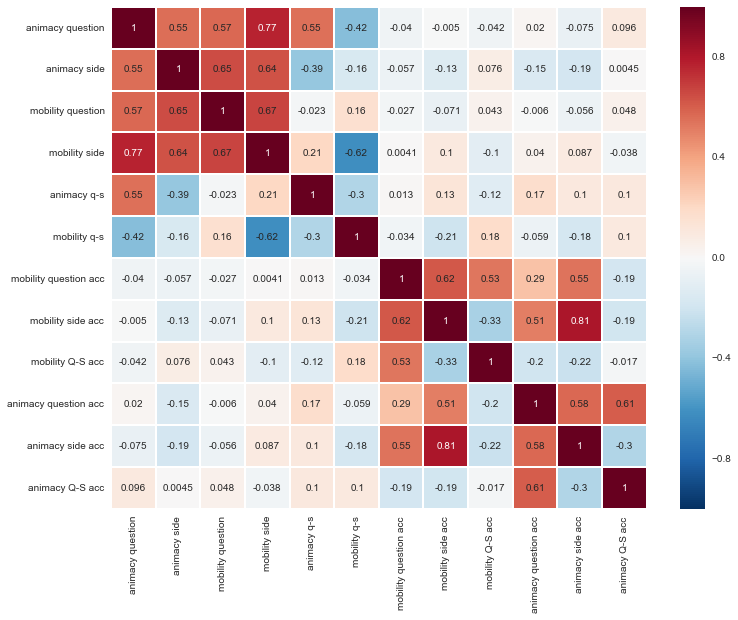

In [274]:
# Correlation map with 10 electrodes from MUT analysis and retrieval accuracy data
corr2 = uv_acc_new.corr()

f, ax = plt.subplots(figsize=(12, 9))
sns.heatmap(corr2, annot=True, linewidths=.5)
plt.show()

## Correlations with self-report and ERPs

### Congruency sequence 

This is **low priority**--only one reviewer mentioned it and I've never found anything great with this . . . 

One way this will differ from what I did before is that this time, at the reviewer's suggestion, I'm including the Odd/Even trials . . . 

The basic question is, can healthy and depressed adults reconfigure set just as easily or no? Let's keep it simple at first, just add a 'cue_1back' column that is either "same" or "different". May ultimately be worthwhile to split this up further to look at switches into or out of an episodic (or conceptual/perceptual) set, but let's start with the basics.

In [ ]:
dfs = []
for sub in erp_ret.subject.unique():
    df = erp_ret[erp_ret.subject == sub]
    df['cue_1b'] = df.cue.shift(1)
    dfs.append(df)
erp_ret = pd.concat(dfs)
erp_ret[['cue','cue_1b']].head()

In [ ]:
def AddSetSwitch(data):
    '''If cue on current trial and trial 1back are same, no switch, otherwise switch.'''
    cue, cue_1b = data
    if pd.isnull(cue) or pd.isnull(cue_1b):
        switch = np.nan
    elif cue == cue_1b:
        switch = 'no'
    else:
        switch = 'yes'
    
    return switch

In [ ]:
erp_ret['switch'] = erp_ret[['cue','cue_1b']].apply(AddSetSwitch,axis=1)

In [ ]:
erp_ret[['cue','cue_1b','switch']].head()

In [ ]:
# First question: is guessing affected by switching? Looks like you might have a Group x Switch interaction there.
sns.factorplot(y='guess',x='switch',hue='group',units='subject',ci=68,kind='bar',
               data=erp_ret)

In [ ]:
# This shows a trend for a group difference in guessing, but neither the switch effect nor the GxS is sig.
erp_ret['switch_FX'] = erp_ret.switch.replace(to_replace={'no':-1,'yes':1})
erp_switch = erp_ret[(erp_ret.switch == 'no') | (erp_ret.switch == 'yes')]

%Rpush erp_switch
%R erp_switch$group_FX <- as.factor(erp_switch$group_FX)
%R erp_switch$gender_FX <- as.factor(erp_switch$gender_FX)
%R erp_switch$switch_FX <- as.factor(erp_switch$switch_FX)

%R switch_guess <- glmer(guess ~ Age + gender_FX + group_FX*switch_FX + (1|word) + (1|subject),\
                         glmerControl(optimizer="bobyqa", optCtrl = list(maxfun = 100000)),\
                         family=binomial, data=erp_switch)

%R print(summary(switch_guess))                         

In [ ]:
# How about accuracy once guesses are removed? Maybe a tiny negative effect . . . 
sns.factorplot(y='accuracy',x='switch',hue='group',units='subject',ci=68,kind='bar',
               data=erp_switch[~(erp_switch.response == 3)])

In [ ]:
# Big effects of Age and Gender on accuracy, but no effect of Group or Switch and no interaction . . . 
erp_switch_nog = erp_switch[~(erp_switch.response == 3)]

%Rpush erp_switch_nog
%R erp_switch_nog$group_FX <- as.factor(erp_switch_nog$group_FX)
%R erp_switch_nog$gender_FX <- as.factor(erp_switch_nog$gender_FX)
%R erp_switch_nog$switch_FX <- as.factor(erp_switch_nog$switch_FX)

%R switch_acc <- glmer(accuracy ~ Age + gender_FX + group_FX*switch_FX + (1|word) + (1|subject),\
                         glmerControl(optimizer="bobyqa", optCtrl = list(maxfun = 100000)),\
                         family=binomial, data=erp_switch_nog)

%R print(summary(switch_acc))                         

In [ ]:
# How about RT? Looks like a slow-down
sns.factorplot(y='RT',x='switch',hue='group',units='subject',ci=68,kind='bar',
               data=erp_switch_nog)

In [ ]:
# Strong effects of Gender and Switch on RT, there is also a Group x Switch interaction but judging by the graph,
# the follow-ups would not be significant.

%R switch_RT <- lmer(RT ~ Age + gender_FX + group_FX*switch_FX + (1|word) + (1|subject), data=erp_switch_nog)

%R print(summary(switch_RT))                         

In [ ]:
# How about confidence? doesn't look like much of an effect there . . . 
sns.factorplot(y='high_confidence',x='switch',hue='group',units='subject',ci=68,kind='bar',
               data=erp_switch_nog)

In [ ]:
# There is a reliable effect of switching on confidence . . . 
%R switch_conf <- glmer(high_confidence ~ Age + gender_FX + group_FX*switch_FX + (1|word) + (1|subject),\
                         glmerControl(optimizer="bobyqa", optCtrl = list(maxfun = 100000)),\
                         family=binomial, data=erp_switch_nog)

%R print(summary(switch_conf))                         